In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SMALL_FONT_SIZE = 12
MEDIUM_FONT_SIZE = 16
LARGE_FONT_SIZE = 20
XLARGE_FONT_SIZE = 24

plt.rc("font", size=MEDIUM_FONT_SIZE)
plt.rc("axes", titlesize=LARGE_FONT_SIZE)
plt.rc("axes", labelsize=LARGE_FONT_SIZE)
plt.rc("xtick", labelsize=MEDIUM_FONT_SIZE)
plt.rc("ytick", labelsize=MEDIUM_FONT_SIZE)
plt.rc("legend", fontsize=MEDIUM_FONT_SIZE)
plt.rc("figure", titlesize=LARGE_FONT_SIZE)

# Define a function for plotting the main metric for an evaluation task

In [34]:
def plot_main_metric(models, dataset, evaluation, task, include_spikeins, include_downsampling_schemes, y_lim_low=0.5, suffix=""):
    sns.set_style("ticks")
    
    fig, axes = plt.subplots(1, len(models), figsize=(15, 6), sharey=False)

    for i, model in enumerate(models):
        ax = axes[i]

        print("plotting:")
        print(evaluation, model, dataset)

        if task == "classification":
            metric = "micro_f1"
            y_label = "Micro F1 Score"
        if task == "integration":
            metric = "avg_bio"
            y_label = "Avg. BIO"

        if evaluation == "finetune" and task == "classification":
            metrics_df = pd.read_csv(f"metrics_csvs/{model}_finetune_classification_eval_results.csv", index_col=0)
            logistic_regression_baseline_df = pd.read_csv(f"metrics_csvs/finetune_classification_logistic_regression_variable_genes_baselines.csv", index_col=0)
            logistic_regression_baseline_df = logistic_regression_baseline_df[logistic_regression_baseline_df.dataset == dataset]

            logistic_regression_baseline = logistic_regression_baseline_df["micro_f1"][0]

        if evaluation == "zeroshot" and task == "classification":
            metrics_df = pd.read_csv(f"metrics_csvs/{model}_zeroshot_classification_eval_results.csv", index_col=0)
            hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_variable_genes_baselines.csv", index_col=0)
            pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_pca_baselines.csv", index_col=0)

        if evaluation == "zeroshot" and task == "integration":
            metrics_df = pd.read_csv(f"metrics_csvs/{model}_zeroshot_integration_eval_results.csv", index_col=0)

            hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_variable_genes_baselines.csv", index_col=0)
            pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_pca_baselines.csv", index_col=0)
        
        # subset to the dataset of interest
        metrics_df = metrics_df[metrics_df.dataset == dataset]

        # default matplotlib colors:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        
        # subset to remove downsampling schemes for spikein supplemental figures
        if not include_downsampling_schemes:
            metrics_df = metrics_df[metrics_df.downsampling_method != "geometric_sketching"]
            metrics_df = metrics_df[metrics_df.downsampling_method != "celltype_reweighted"]
            #metrics_df = metrics_df[metrics_df.percentage < 50] # todo remove this

            # remove the colors used for the two schemes
            colors.remove('#ff7f0e')
            colors.remove('#2ca02c',) 

        # subset to remove spikeins for main text figures
        if not include_spikeins:
            metrics_df = metrics_df[metrics_df.downsampling_method != "spikein_10"]
            metrics_df = metrics_df[metrics_df.downsampling_method != "spikein_50"]


        if evaluation == "zeroshot":
            hvg_baseline_df = hvg_baseline_df[hvg_baseline_df.dataset == dataset]
            pca_baseline_df = pca_baseline_df[pca_baseline_df.dataset == dataset]
            hvg_baseline = hvg_baseline_df[metric][0]
            pca_baseline = pca_baseline_df[metric][0]


        # rename categories for plotting
        metrics_df["downsampling_method"] = pd.Categorical(metrics_df["downsampling_method"]).rename_categories({
            'randomsplits': 'Random', 
            'random': 'Random', 
            'celltype_reweighted': 'Cell Type\nReweighted',
            'geometric_sketch': "Geometric Sketching",
            'geometric_sketching': "Geometric Sketching",
            'spikein_10': "Spike-in (10%)",
            'spikein_50': "Spike-in (50%)",
            })

        LINEWIDTH = 3
        
        # main plot
        sns.lineplot(x='percentage',
                     y=metric,
                     hue='downsampling_method',
                     data=metrics_df,
                     errorbar='se',
                     linewidth=LINEWIDTH,
                     ax = ax,
                     palette=colors)

        # add horizontal lines for baselines
        if evaluation == "finetune":
            # add line for logistic regression
            ax.hlines(y=logistic_regression_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Logistic\nRegression Baseline', linewidth=LINEWIDTH)
        if evaluation == "zeroshot":
            # add line for HVGs
            ax.hlines(y=hvg_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Baseline', linewidth=LINEWIDTH)
            # add line for PCA
            ax.hlines(y=pca_baseline, xmin=0, xmax=100, color='black', linestyle='dashed', label='PCA Baseline', linewidth=LINEWIDTH)

        # set axes and legend
        ax.grid(False)
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.set_xlim([0, 100])
        ax.set_ylim([y_lim_low, 1.0])
        ax.title.set_text(model)

        ax.get_legend().remove() # have one legend for all models

        # remove top and right spines from axis
        ax.spines[['right', 'top']].set_visible(False)

        # set axis line widths
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(LINEWIDTH)


    if evaluation == "zeroshot":
        title = "Zero-Shot"
    if evaluation == "finetune":
        title = "Fine-Tuned"

    fig.suptitle(title + suffix, fontsize=XLARGE_FONT_SIZE, y=1.01)

    fig.supxlabel("Percentage of Full Pre-Training Dataset", y=0.2)
    fig.supylabel(y_label, y = 0.25 + 0.375, x=0.07)

    # grab legend labels from subplot
    handles, labels = axes[0].get_legend_handles_labels()

    # add legend blow plots
    fig.subplots_adjust(bottom=0.35)
    #fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), title='Downsampling Method', ncol=5)
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), title='', ncol=5)

    plot_file = f"figures/lineplots/{dataset}_{evaluation}_{task}{suffix}.png"
    print("Saving:", plot_file)
    plt.savefig(plot_file, bbox_inches="tight", dpi=1200)

# Figure 2: Plot Micro F1 score for hematopoiesis dataset

plotting:
zeroshot PretrainedPCA hematopoiesis
plotting:
zeroshot scVI hematopoiesis
plotting:
zeroshot SSL hematopoiesis
plotting:
zeroshot Geneformer hematopoiesis


/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',


Saving: figures/lineplots/hematopoiesis_zeroshot_classification.png
plotting:
finetune scVI hematopoiesis
plotting:
finetune SSL hematopoiesis
plotting:
finetune Geneformer hematopoiesis
Saving: figures/lineplots/hematopoiesis_finetune_classification.png


/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x='percentage',


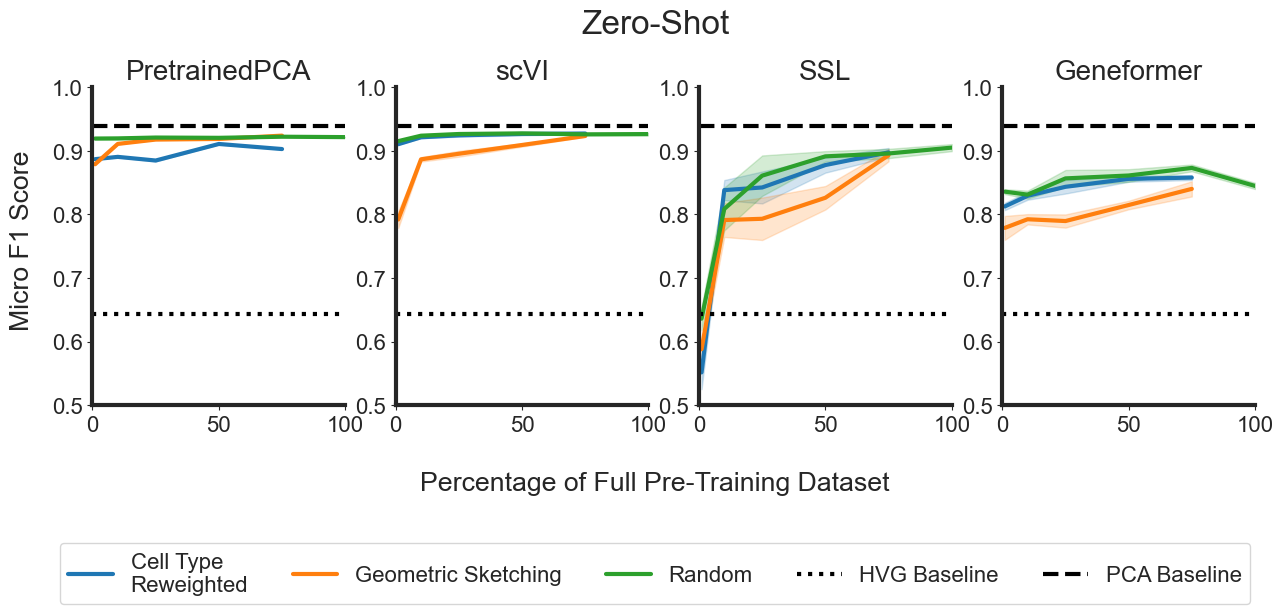

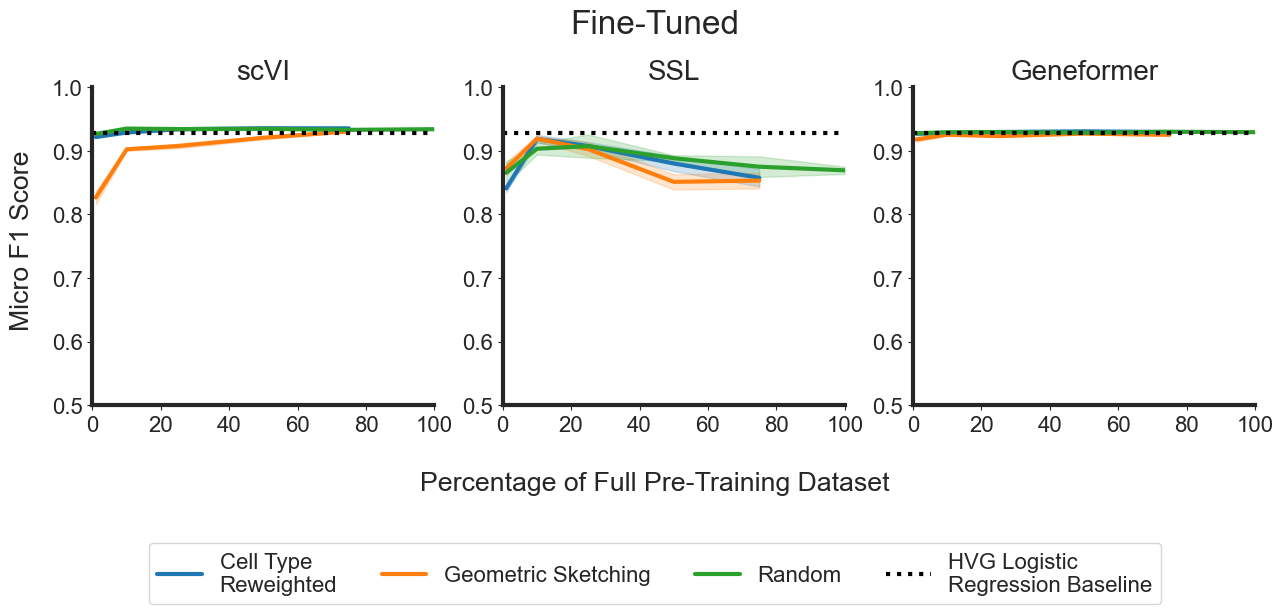

In [35]:
models = ["PretrainedPCA", "scVI", "SSL", "Geneformer"]
dataset = "hematopoiesis"
include_spikeins = False
include_downsampling_schemes = True

plot_main_metric(models, dataset, "zeroshot", "classification", include_spikeins, include_downsampling_schemes)

models = ["scVI", "SSL", "Geneformer"]

plot_main_metric(models, dataset, "finetune", "classification", include_spikeins, include_downsampling_schemes)

#dataset = "pbmc12k"
#plot_main_metric(models, dataset, "zeroshot", "integration", include_spikeins, include_downsampling_schemes)



# Define functions for plotting all metrics for each task and dataset

In [36]:
def metrics_line_plots(evaluation, task, dataset, columns_to_plot, ylabels, title):
    print(evaluation, task, dataset)

    models = ["scVI", "SSL", "Geneformer"]

    # load baseline(s)
    if evaluation == "finetune" and task == "classification":
        logistic_regression_baseline_df = pd.read_csv(f"metrics_csvs/finetune_classification_logistic_regression_variable_genes_baselines.csv", index_col=0)
        logistic_regression_baseline_df = logistic_regression_baseline_df[logistic_regression_baseline_df.dataset == dataset]

        logistic_regression_baseline = logistic_regression_baseline_df["micro_f1"][0]

    if evaluation == "zeroshot" and task == "classification":
        hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_variable_genes_baselines.csv", index_col=0)
        pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_pca_baselines.csv", index_col=0)

    if evaluation == "zeroshot" and task == "integration":
        hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_variable_genes_baselines.csv", index_col=0)
        pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_pca_baselines.csv", index_col=0)


    if evaluation == "zeroshot":
        hvg_baseline_df = hvg_baseline_df[hvg_baseline_df.dataset == dataset]
        pca_baseline_df = pca_baseline_df[pca_baseline_df.dataset == dataset]

    # plotting
    LINEWIDTH = 3

    sns.set_style("ticks")
    fig, axes = plt.subplots(len(models), len(columns_to_plot), figsize=(30, 15), sharey=False)

    for j, var in enumerate(columns_to_plot):
        for i, model in enumerate(models):
            metrics_df = pd.read_csv(f"metrics_csvs/{model}_{evaluation}_{task}_eval_results.csv", index_col=0)
        
            metrics_df = metrics_df[metrics_df["dataset"] == dataset]
    
    
    
            # rename categories for plotting
            metrics_df["downsampling_method"] = pd.Categorical(metrics_df["downsampling_method"]).rename_categories({
                'randomsplits': 'Random', 
                'random': 'Random', 
                'celltype_reweighted': 'Cell Type Reweighted',
                'geometric_sketch': "Geometric Sketching",
                'geometric_sketching': "Geometric Sketching",
                'spikein_10': "Spike-in (10%)",
                'spikein_50': "Spike-in (50%)",
                })

        
            sns.lineplot(x='percentage', y=var, hue='downsampling_method', data=metrics_df, errorbar='se', ax = axes[i,j], linewidth=LINEWIDTH)
            axes[i,j].grid(False)
            axes[i,j].set_xlabel("")
            axes[i,j].set_ylabel(ylabels[j])
            axes[i,j].legend(title='Downsampling Method')
            axes[i,j].set_xlim([0, 100])
            axes[i,j].set_ylim([0.0, 1.0])
    
            axes[i,j].get_legend().remove() # have one legend for all models
    
    
            # remove top and right spines from axis
            axes[i,j].spines[['right', 'top']].set_visible(False)
    
            # set axis line widths
            for axis in ['bottom', 'left']:
                axes[i,j].spines[axis].set_linewidth(LINEWIDTH)
    
    
            # add horizontal lines for baselines
            if evaluation == "finetune":
                # add line for logistic regression
                axes[i,j].hlines(y=logistic_regression_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Logistic\nRegression Baseline', linewidth=LINEWIDTH)
            if evaluation == "zeroshot":
                hvg_baseline = hvg_baseline_df[var][0]
                pca_baseline = pca_baseline_df[var][0]
    
                # add line for HVGs
                axes[i,j].hlines(y=hvg_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Baseline', linewidth=LINEWIDTH)
                # add line for PCA
                axes[i,j].hlines(y=pca_baseline, xmin=0, xmax=100, color='black', linestyle='dashed', label='PCA Baseline', linewidth=LINEWIDTH)

            
    # grab legend labels from subplot
    handles, labels = axes[0,0].get_legend_handles_labels()

    # add legend blow plots
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles,
               labels,
               loc='lower center',
               bbox_to_anchor=(0.5, 0),
               title='Downsampling Method',
               ncol=7,
               fontsize=24,
               title_fontsize=28)

    fig.supxlabel("Percentage of Full Pre-Training Dataset", y=0.12, fontsize=32)

    fig.suptitle(title, fontsize=40)

    
    # Add row titles
    fig.text(0.01, 0.07 + 3 * 0.235, models[0], va='center', rotation='horizontal', fontsize=32)
    fig.text(0.01, 0.07 + 2 * 0.235, models[1], va='center', rotation='horizontal', fontsize=32)
    fig.text(0.01, 0.07 + 1 * 0.235, models[2], va='center', rotation='horizontal', fontsize=32)

    plot_file = f"figures/lineplots_metrics/{dataset}_{evaluation}_{task}.png"
    print("Saving:", plot_file)
    plt.savefig(plot_file, bbox_inches="tight", dpi=300) # todo bump this to 1200
    

def zero_shot_integration_plot(dataset, dataset_name):
    columns_to_plot = ["NMI_cluster/label", "ARI_cluster/label", "ASW_label", "ASW_batch", "avg_bio"]
    ylabels = ["NMI (cluster/label)", "ARI (cluster/label)", "ASW (label)", "ASW (batch)", "AVG BIO"]
    title = f"Zero-Shot Integration: {dataset_name.capitalize()}"
    metrics_line_plots("zeroshot", "integration", dataset, columns_to_plot, ylabels, title)


def zero_shot_classification_plot(dataset, dataset_name):
    columns_to_plot = ["accuracy", "precision", "recall", "micro_f1", "macro_f1"]
    ylabels = ["Accuracy", "Precision", "Recall", "Micro F1 Score", "Macro F1 Score"]
    title = f"Zero-Shot Classification: {dataset_name.capitalize()}"
    metrics_line_plots("zeroshot", "classification", dataset, columns_to_plot, ylabels, title)


def finetuned_classification_plot(dataset, dataset_name):
    columns_to_plot = ["accuracy", "precision", "recall", "micro_f1", "macro_f1"]
    ylabels = ["Accuracy", "Precision", "Recall", "Micro F1 Score", "Macro F1 Score"]
    title = f"Fine-Tune Classification: {dataset_name.capitalize()}"
    metrics_line_plots("finetune", "classification", dataset, columns_to_plot, ylabels, title)

# Supplemental Figures: Zero-Shot Classification (all metrics)

zeroshot classification hematopoiesis
Saving: figures/lineplots_metrics/hematopoiesis_zeroshot_classification.png
zeroshot classification intestine
Saving: figures/lineplots_metrics/intestine_zeroshot_classification.png
zeroshot classification periodontitis
Saving: figures/lineplots_metrics/periodontitis_zeroshot_classification.png
zeroshot classification placenta
Saving: figures/lineplots_metrics/placenta_zeroshot_classification.png


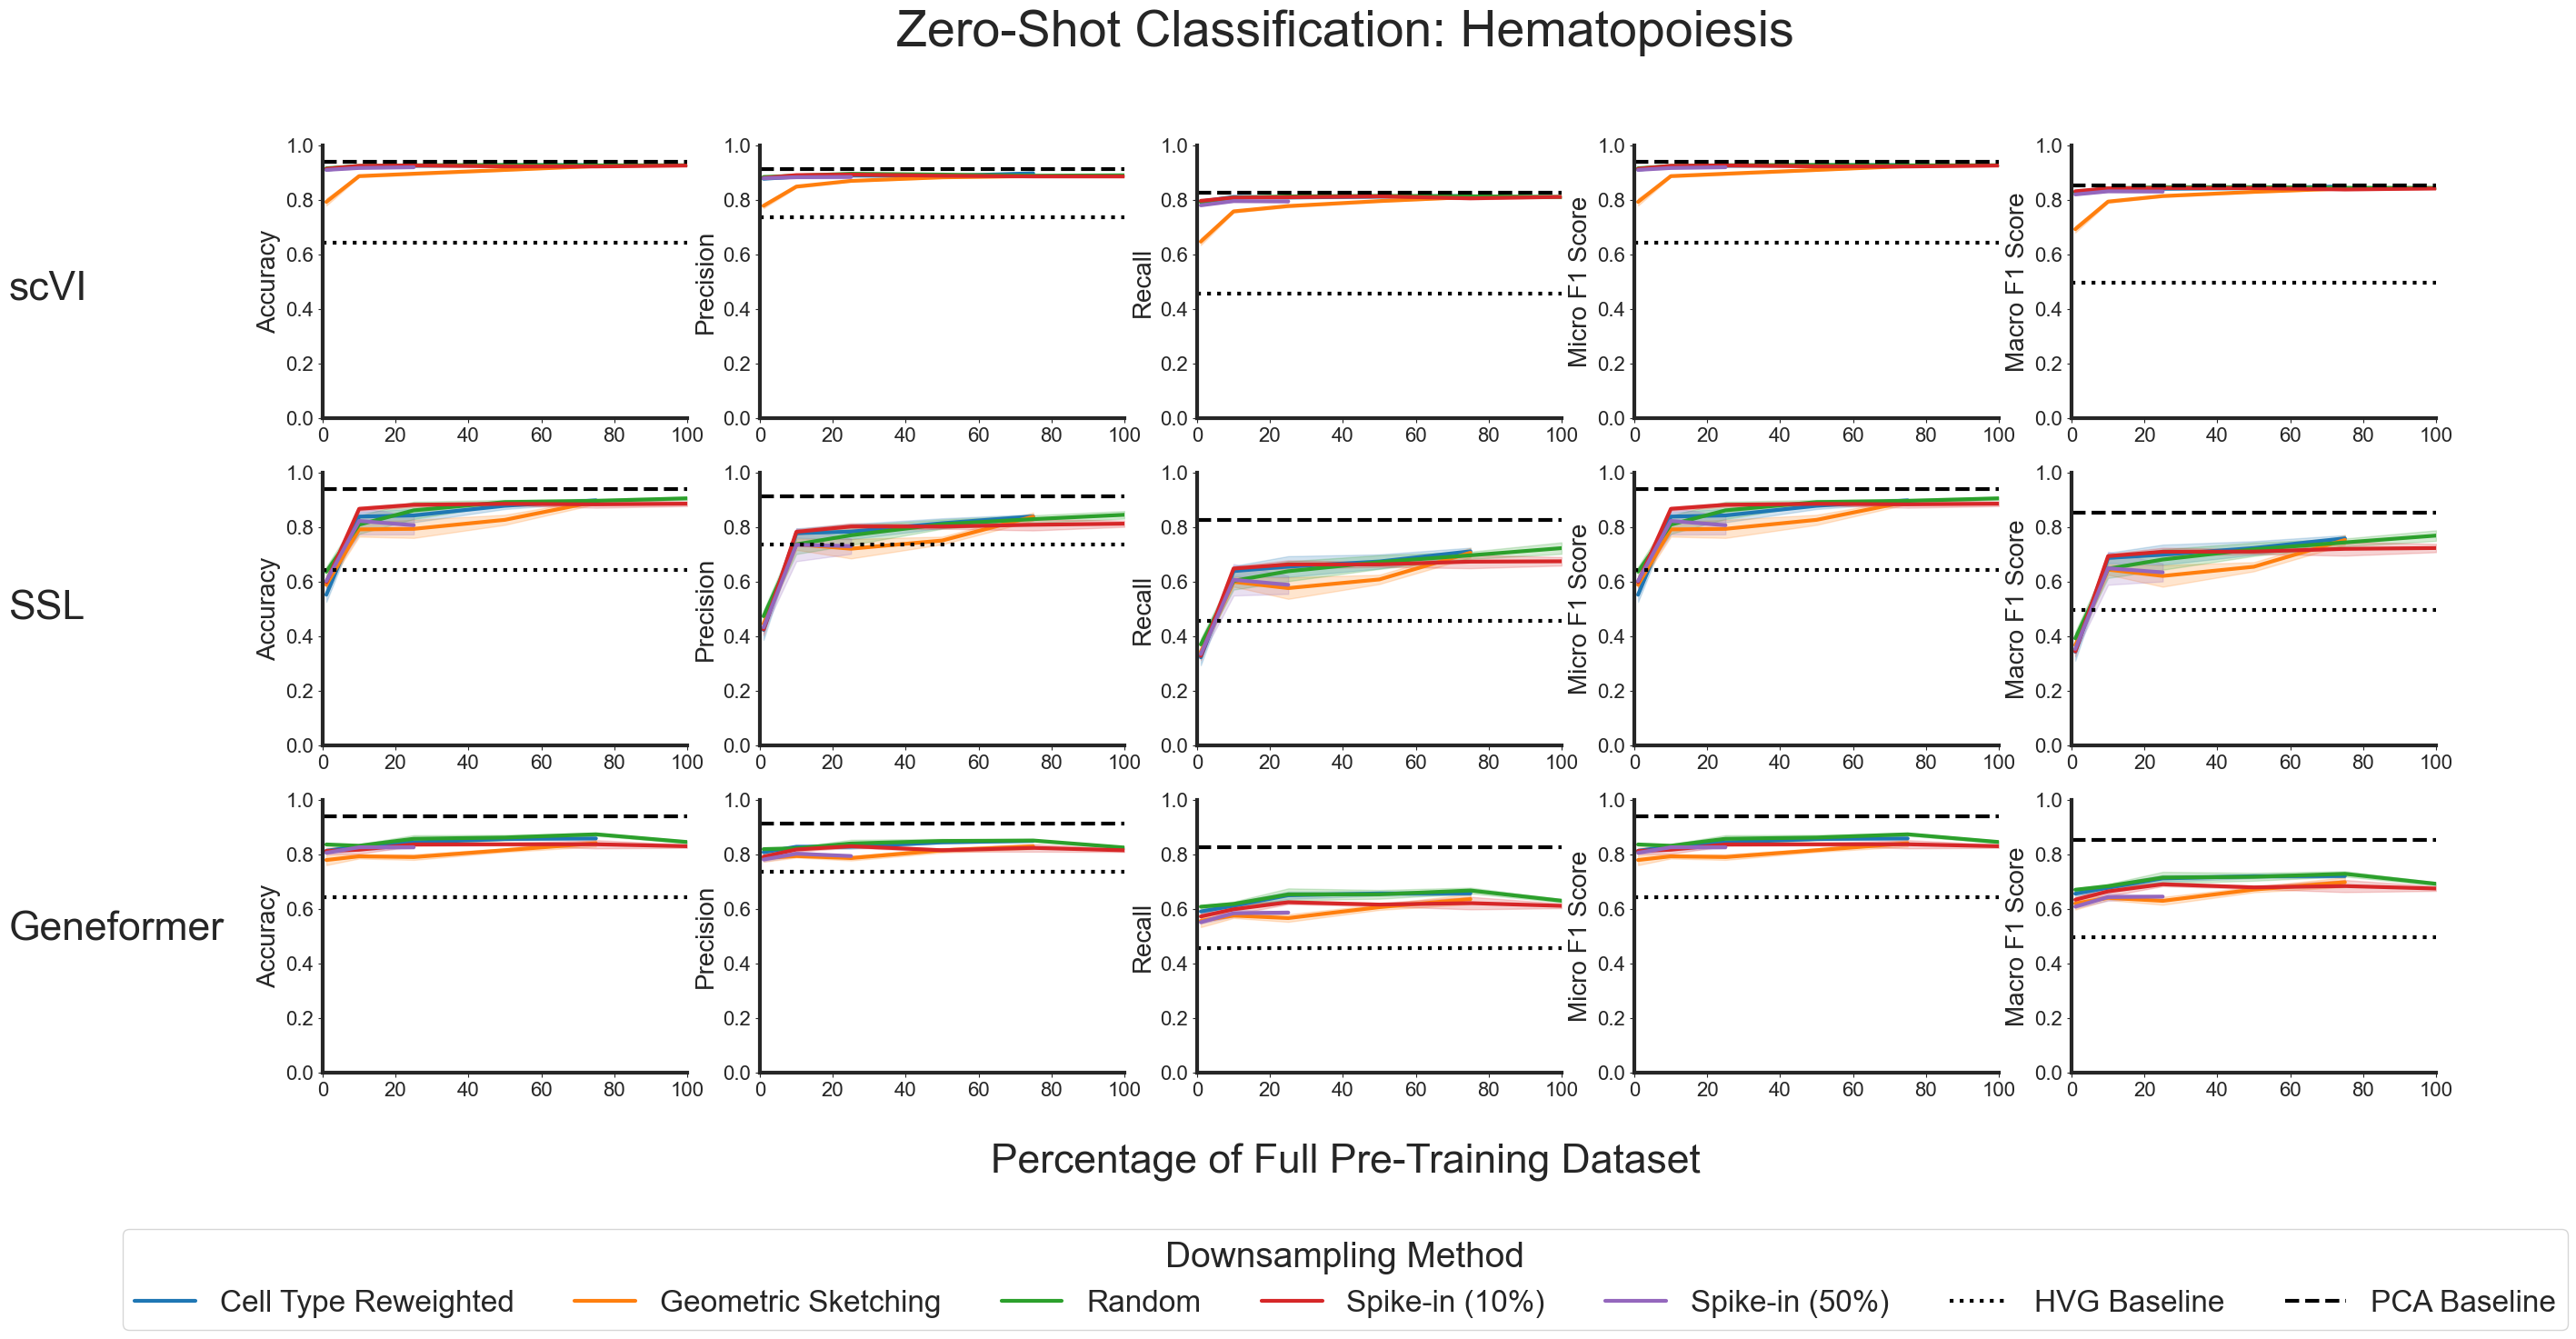

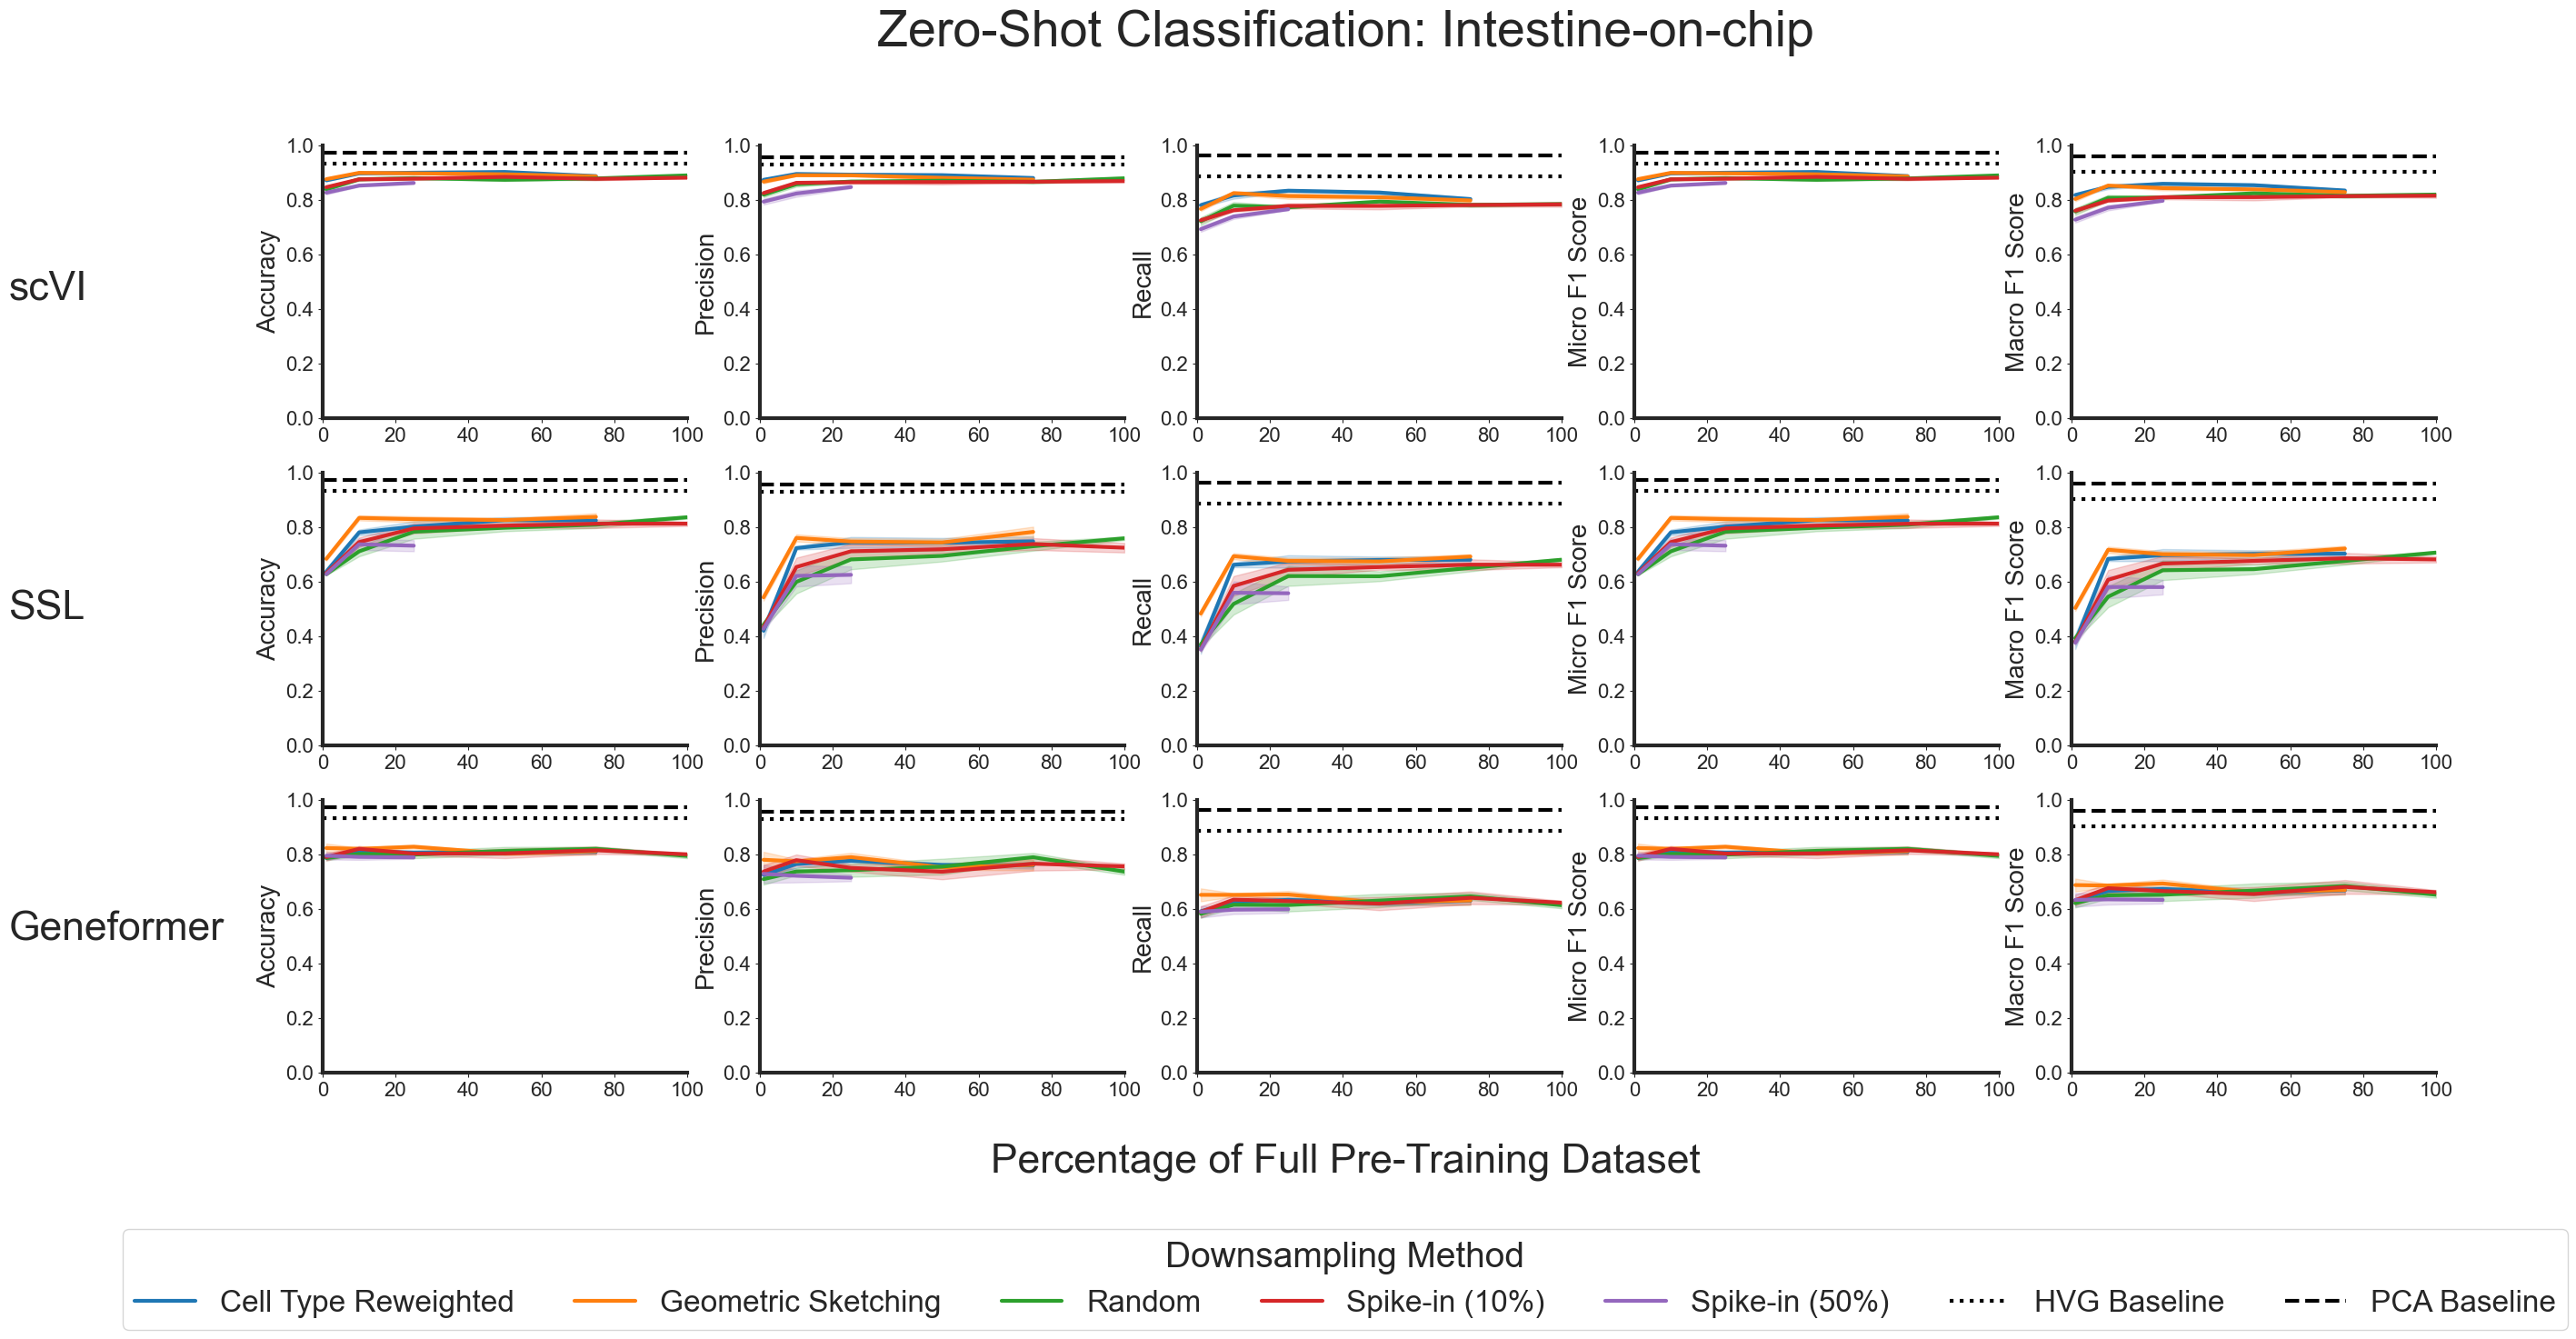

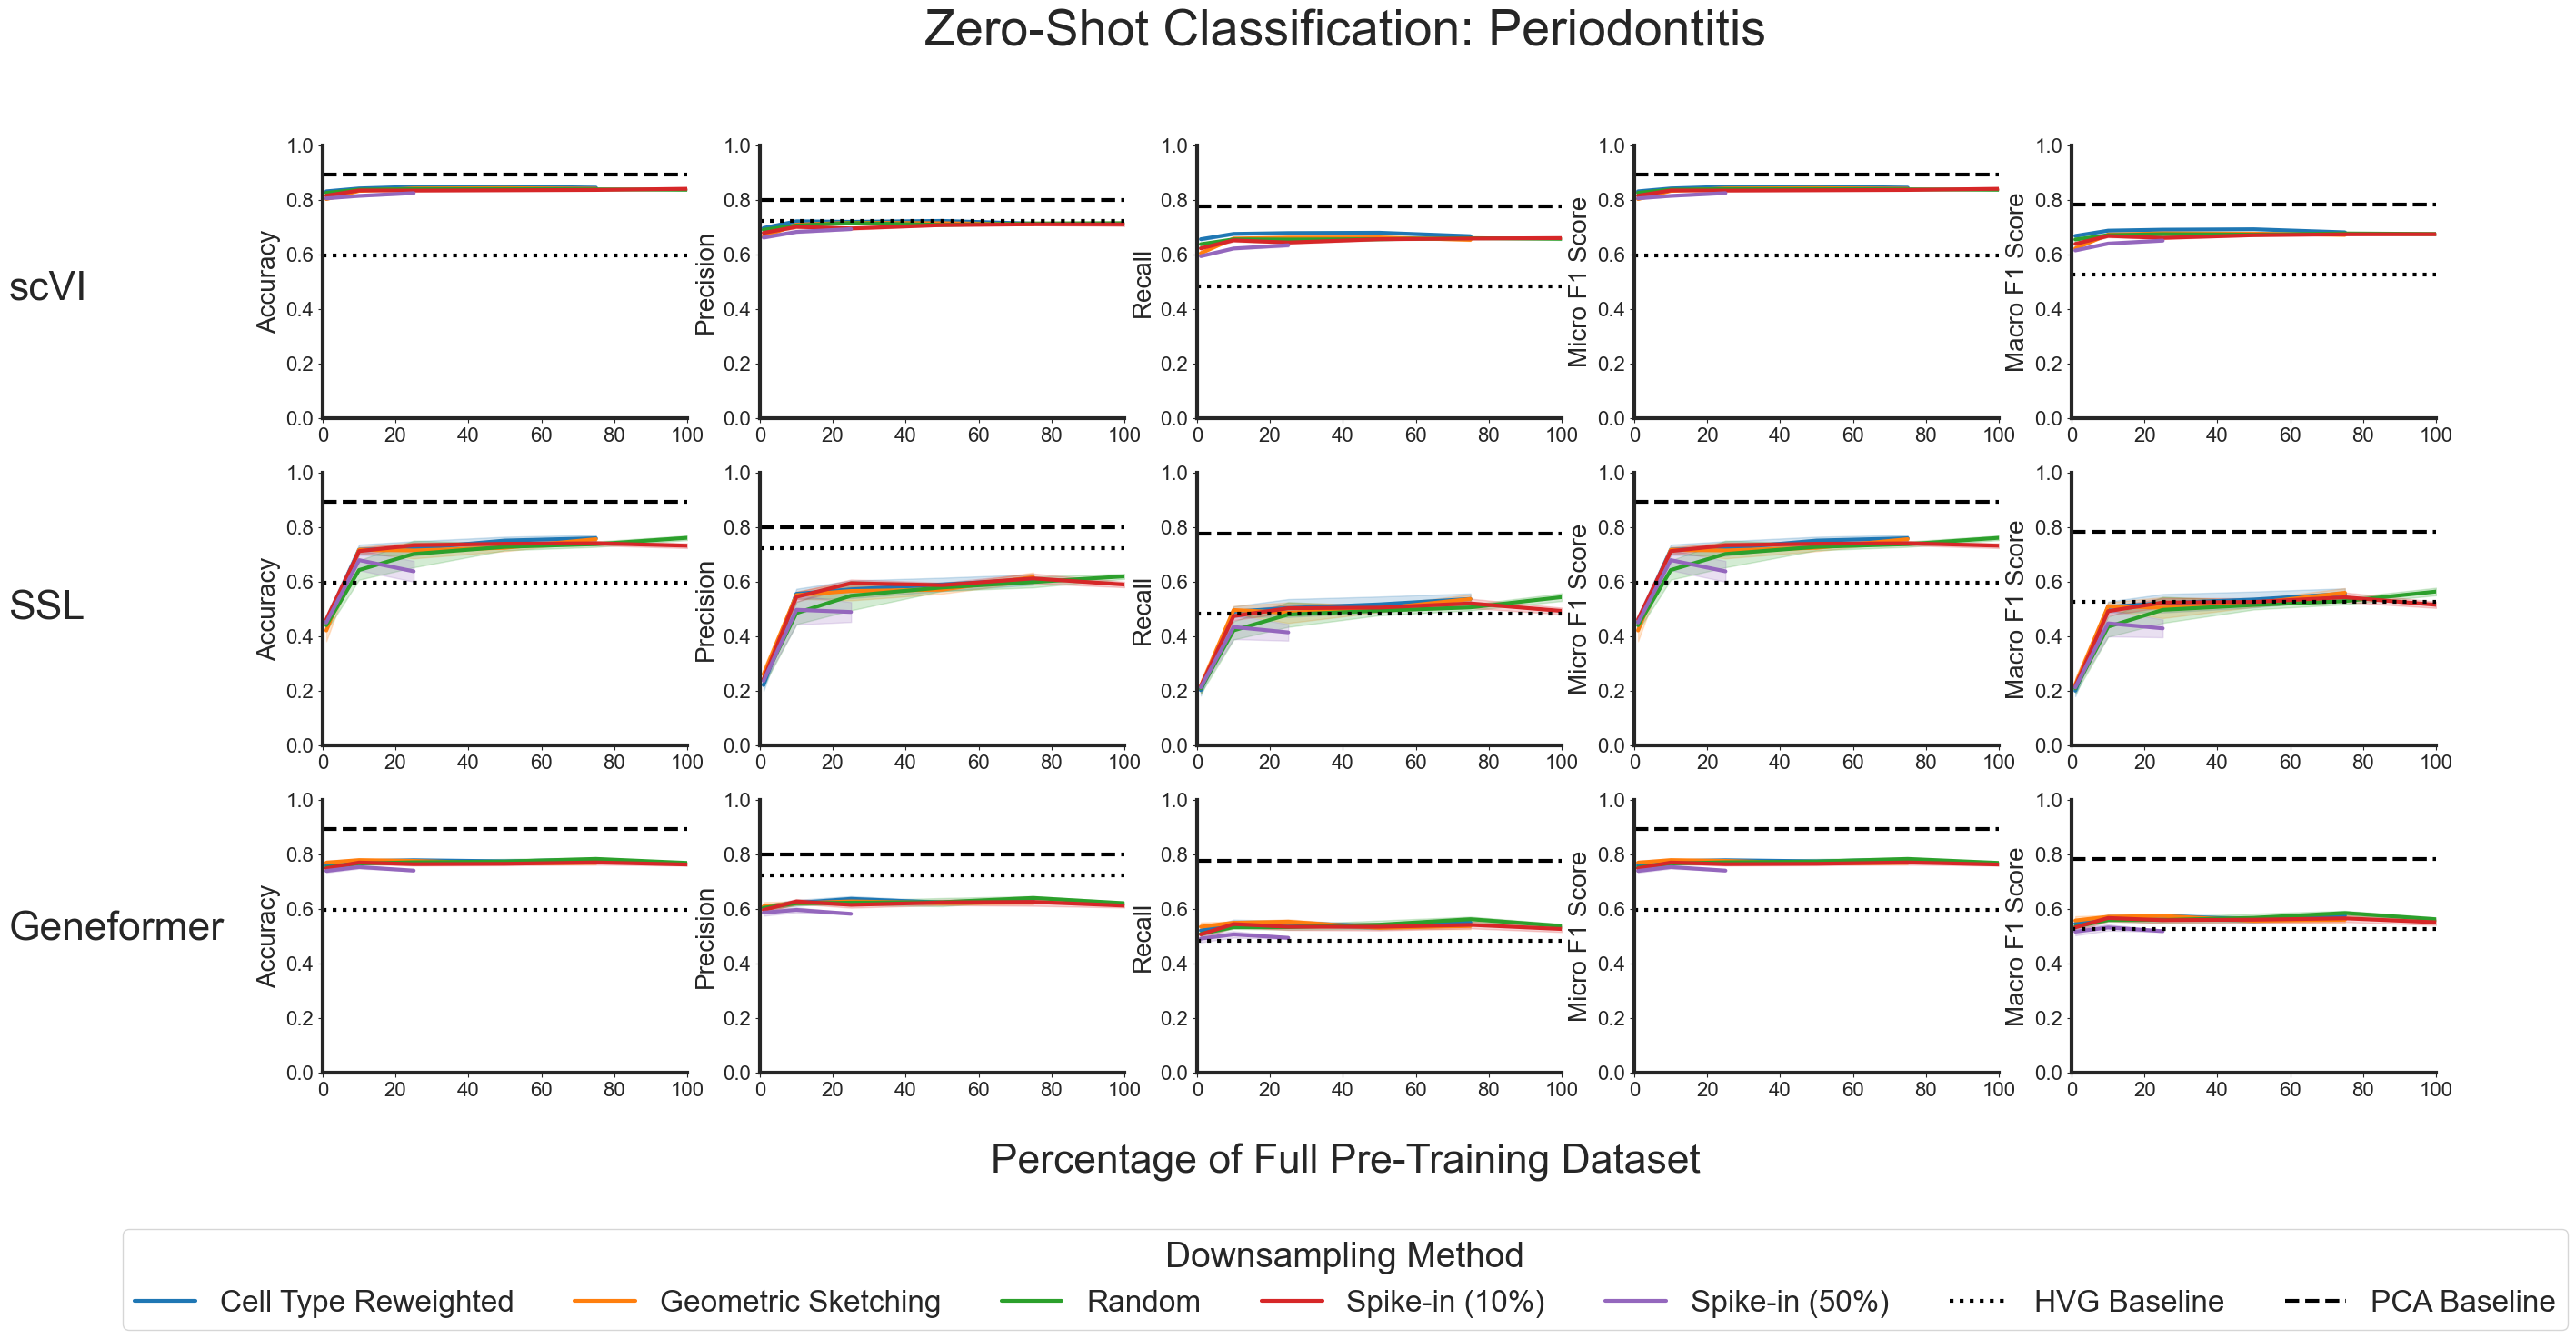

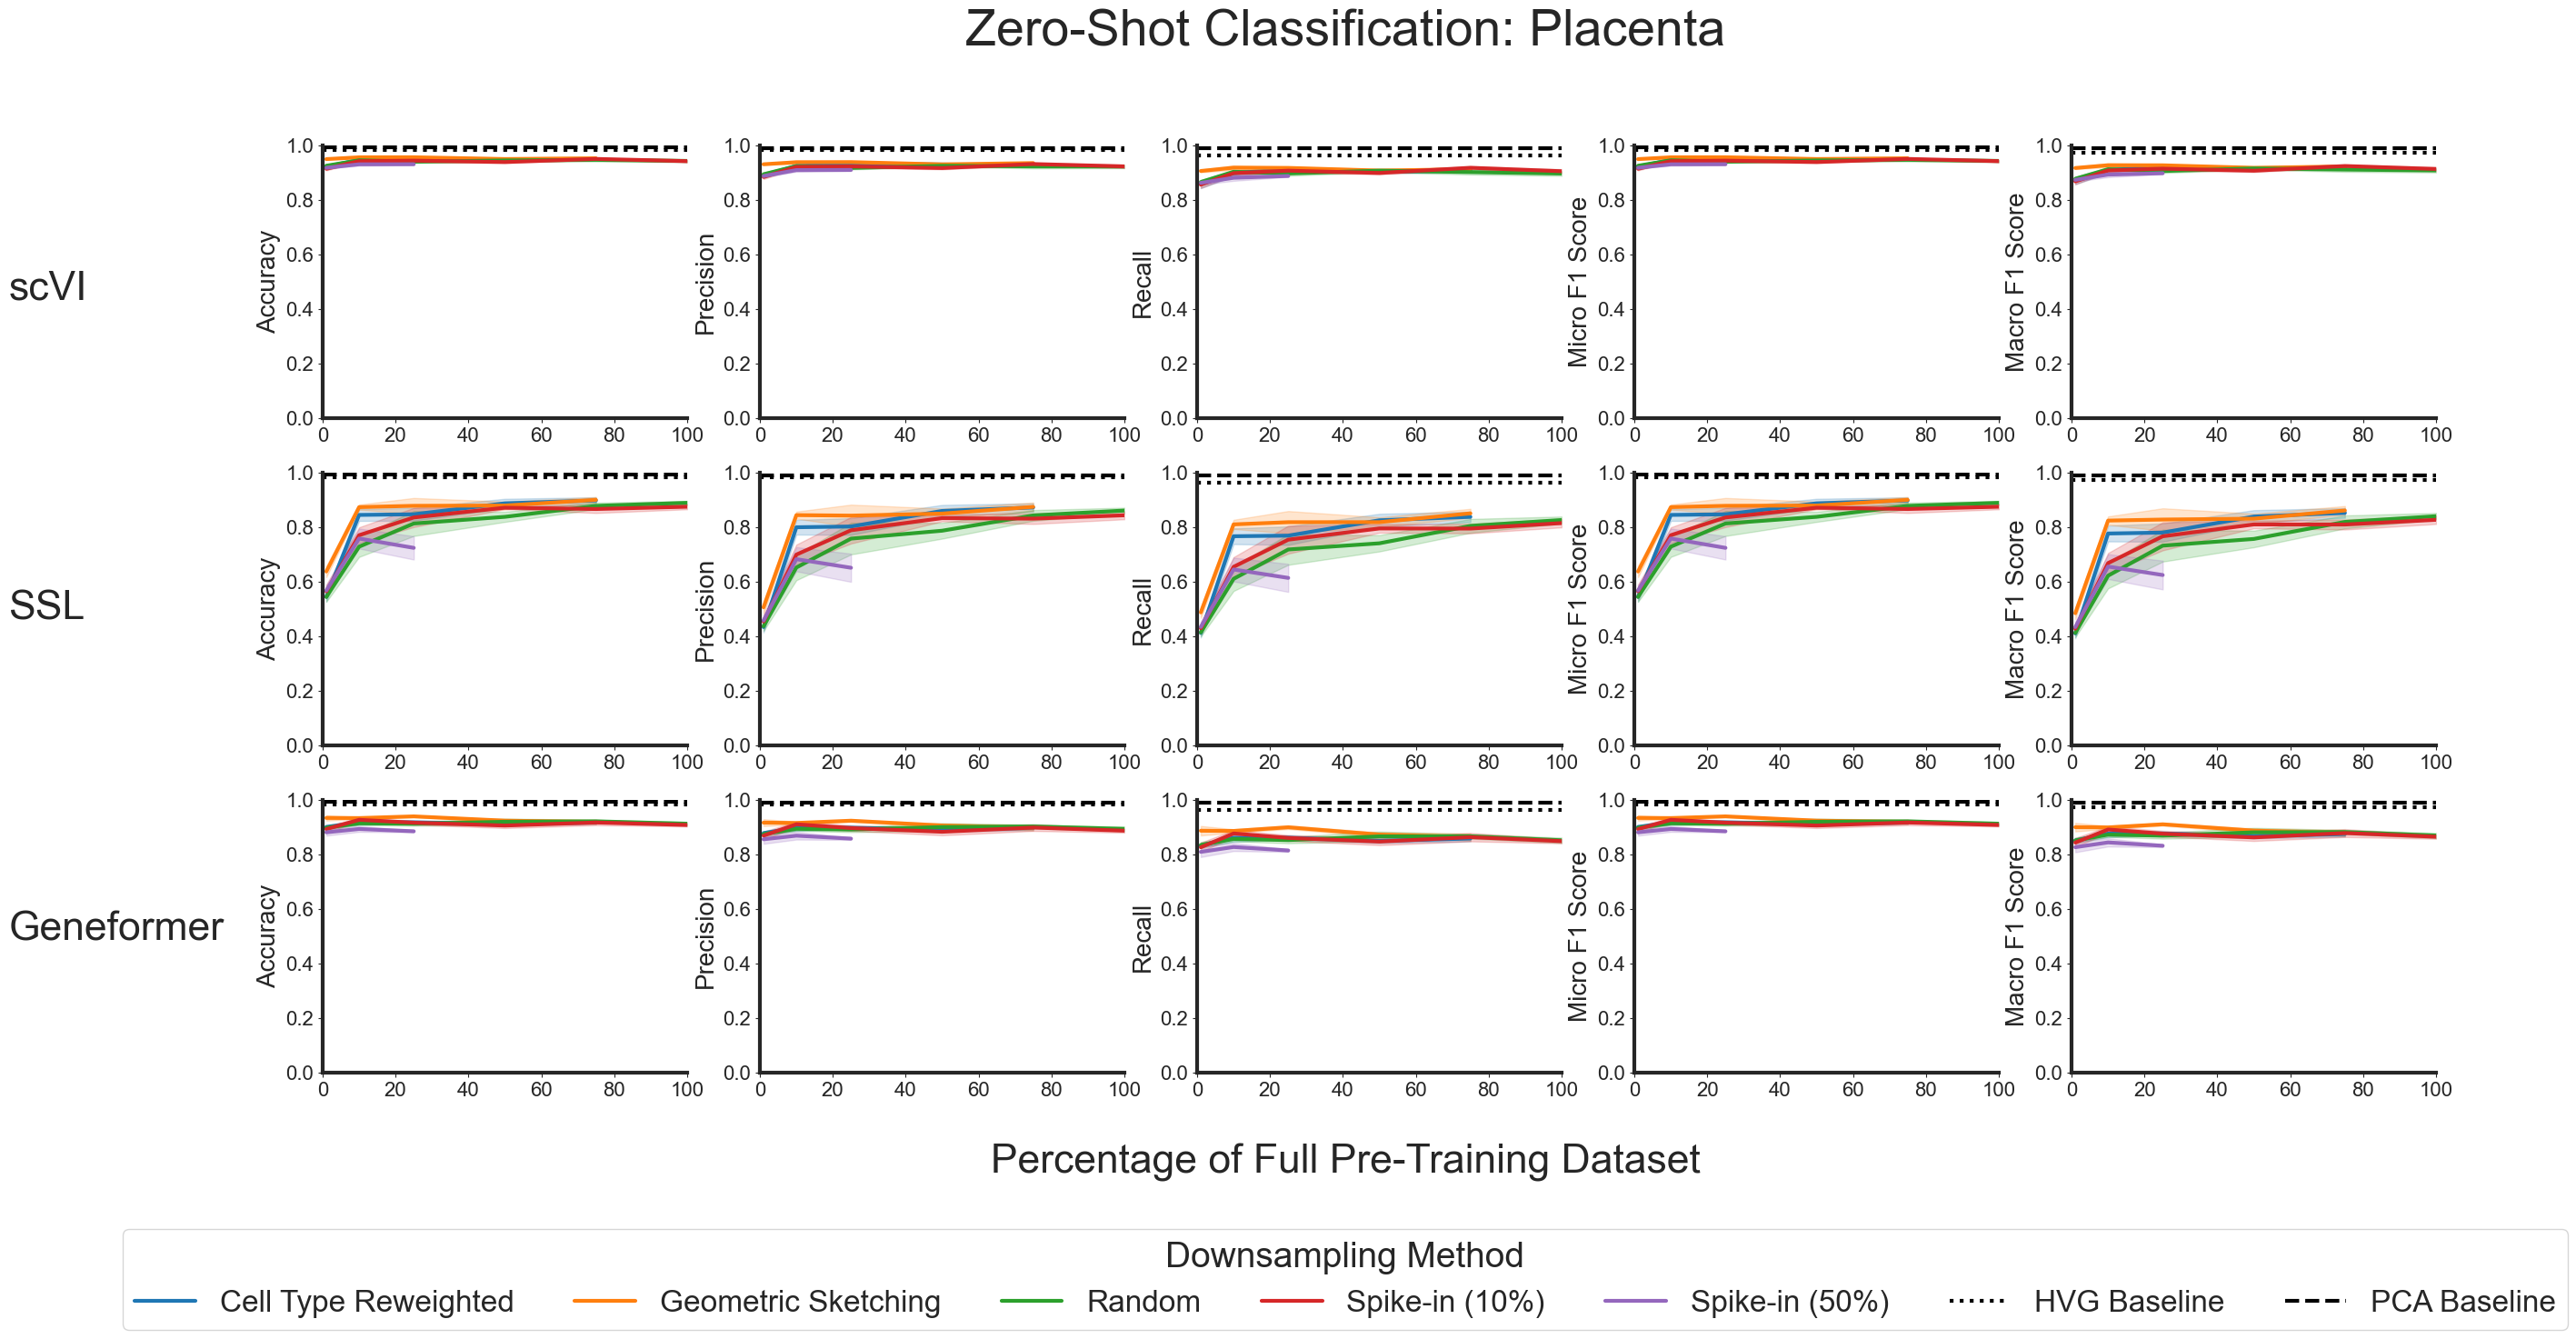

In [37]:
datasets = ["hematopoiesis", "intestine", "periodontitis", "placenta"]

for dataset in datasets:
    dataset_name = dataset.capitalize()
    
    if dataset == "intestine":
        dataset_name = "Intestine-on-Chip"
        
    zero_shot_classification_plot(dataset, dataset_name)


# Supplemental Figures: Fine-Tuned Classification (all metrics)

finetune classification hematopoiesis
Saving: figures/lineplots_metrics/hematopoiesis_finetune_classification.png
finetune classification intestine
Saving: figures/lineplots_metrics/intestine_finetune_classification.png
finetune classification periodontitis
Saving: figures/lineplots_metrics/periodontitis_finetune_classification.png
finetune classification placenta
Saving: figures/lineplots_metrics/placenta_finetune_classification.png


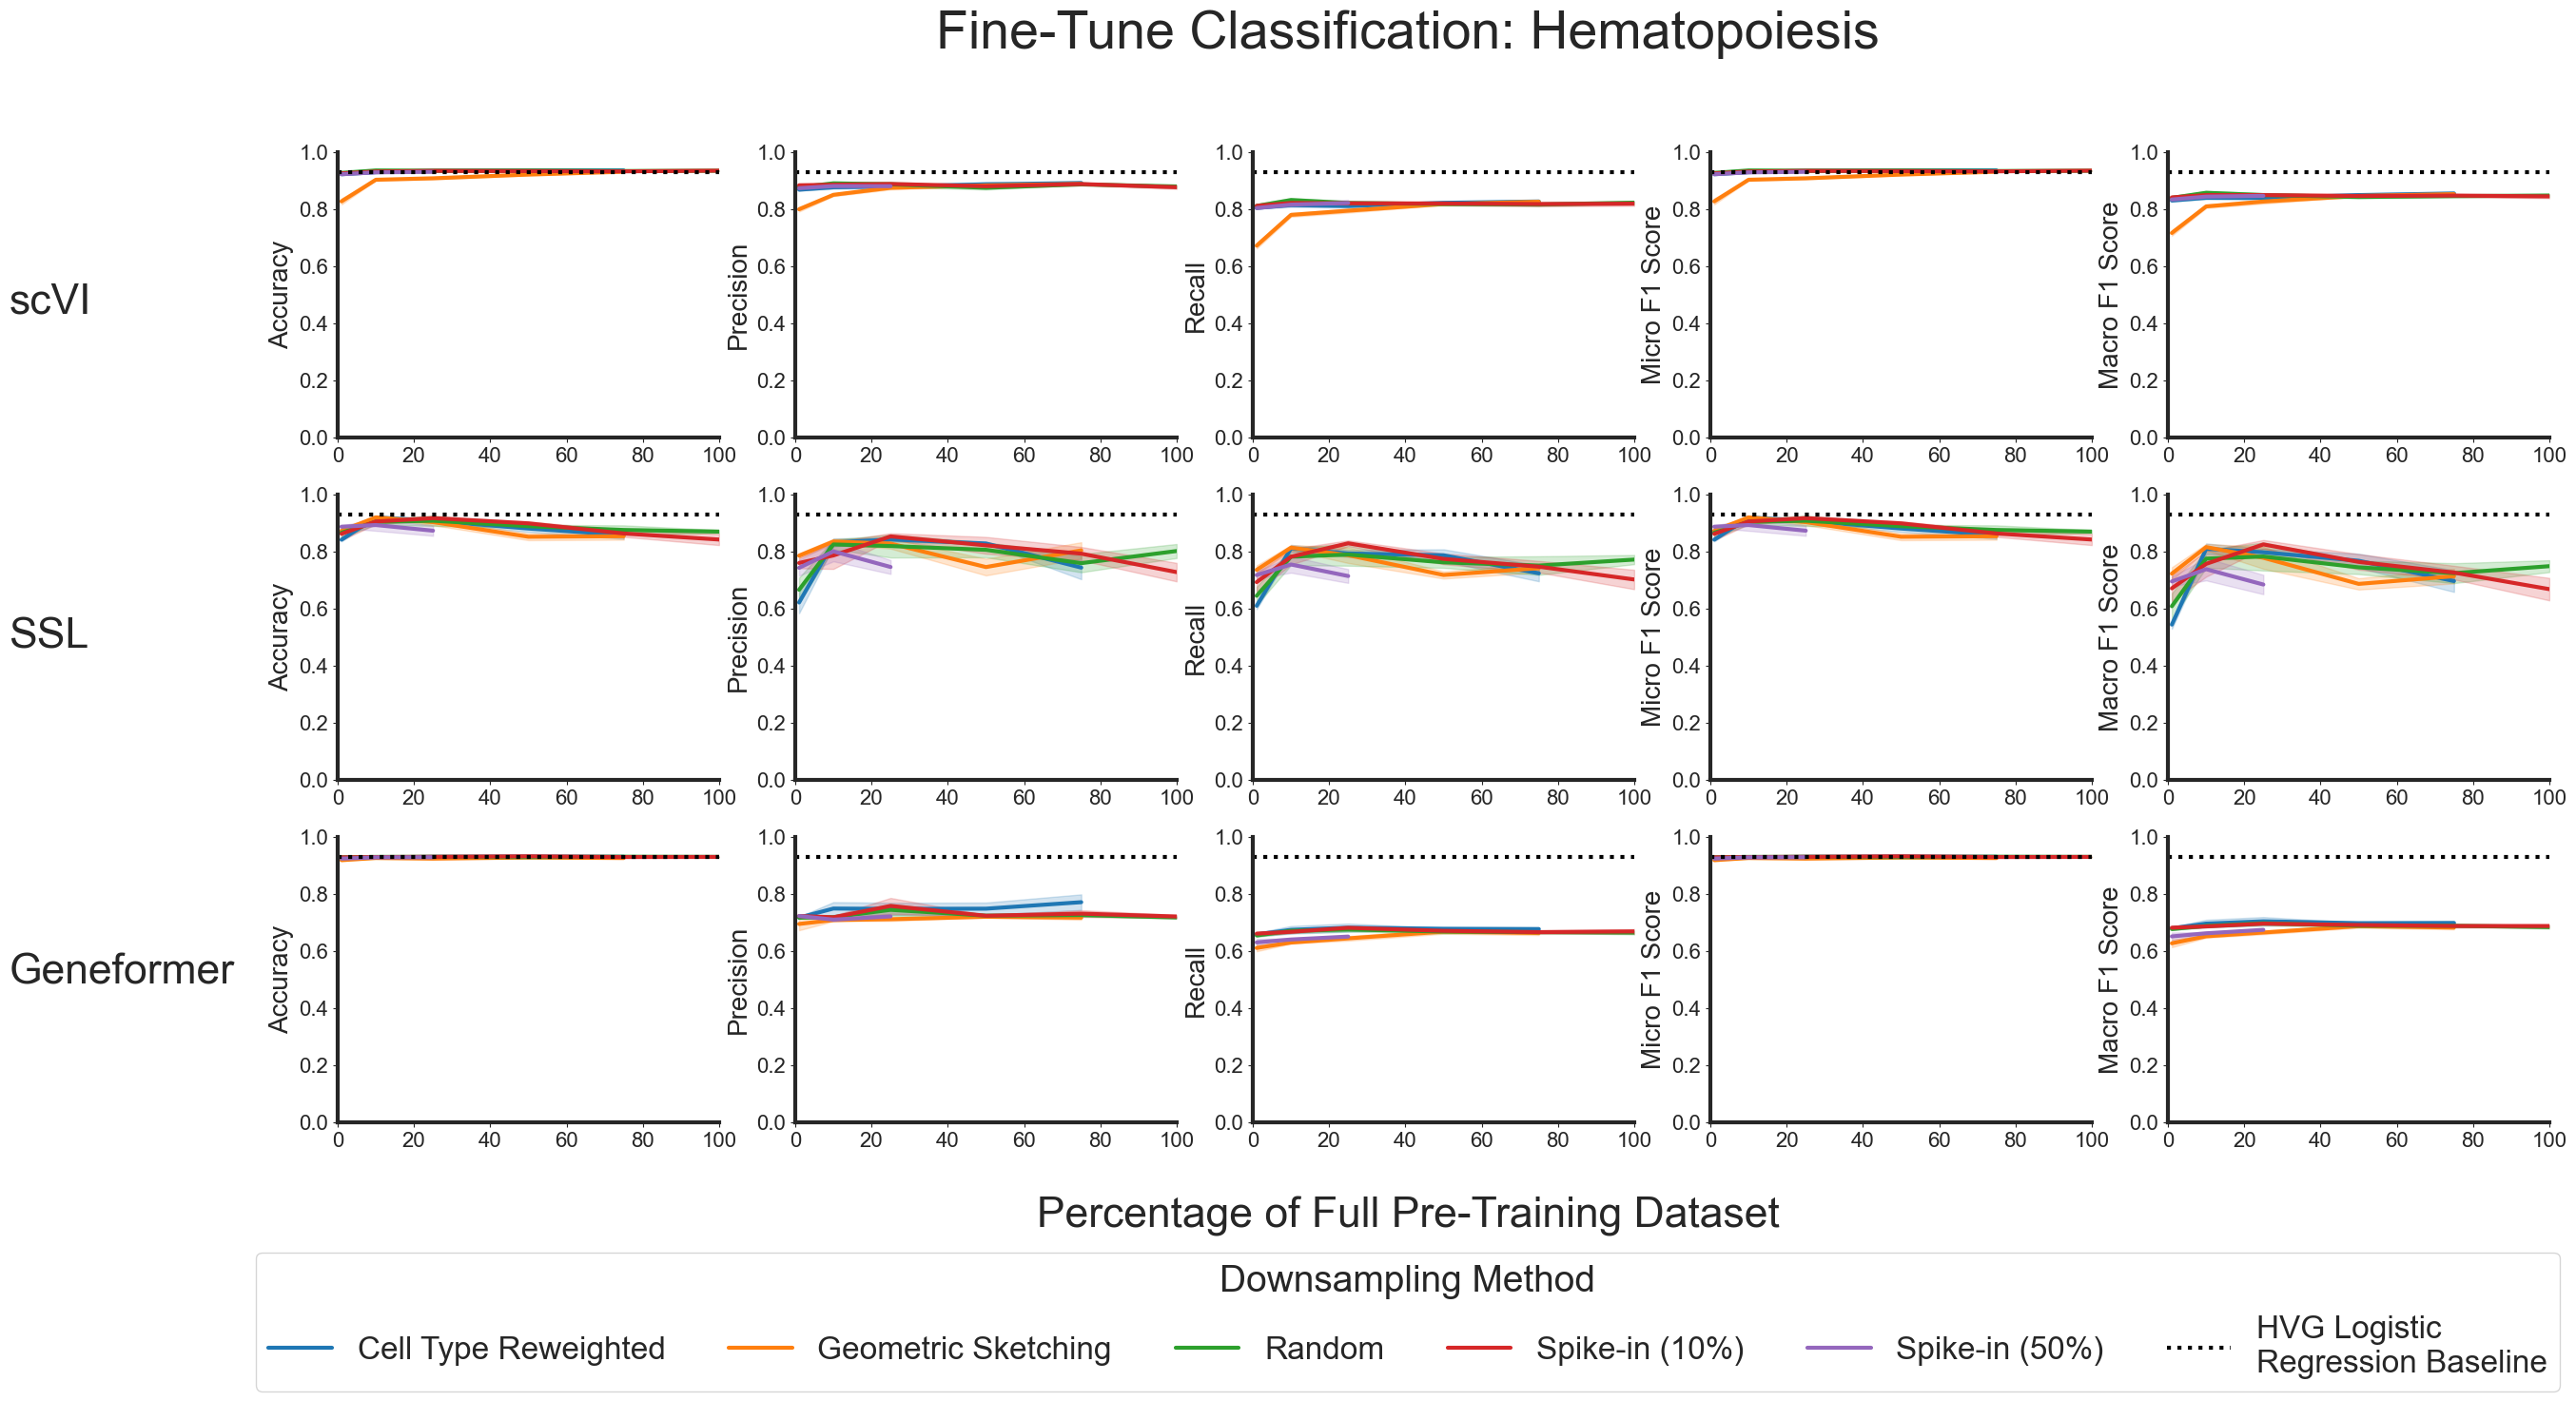

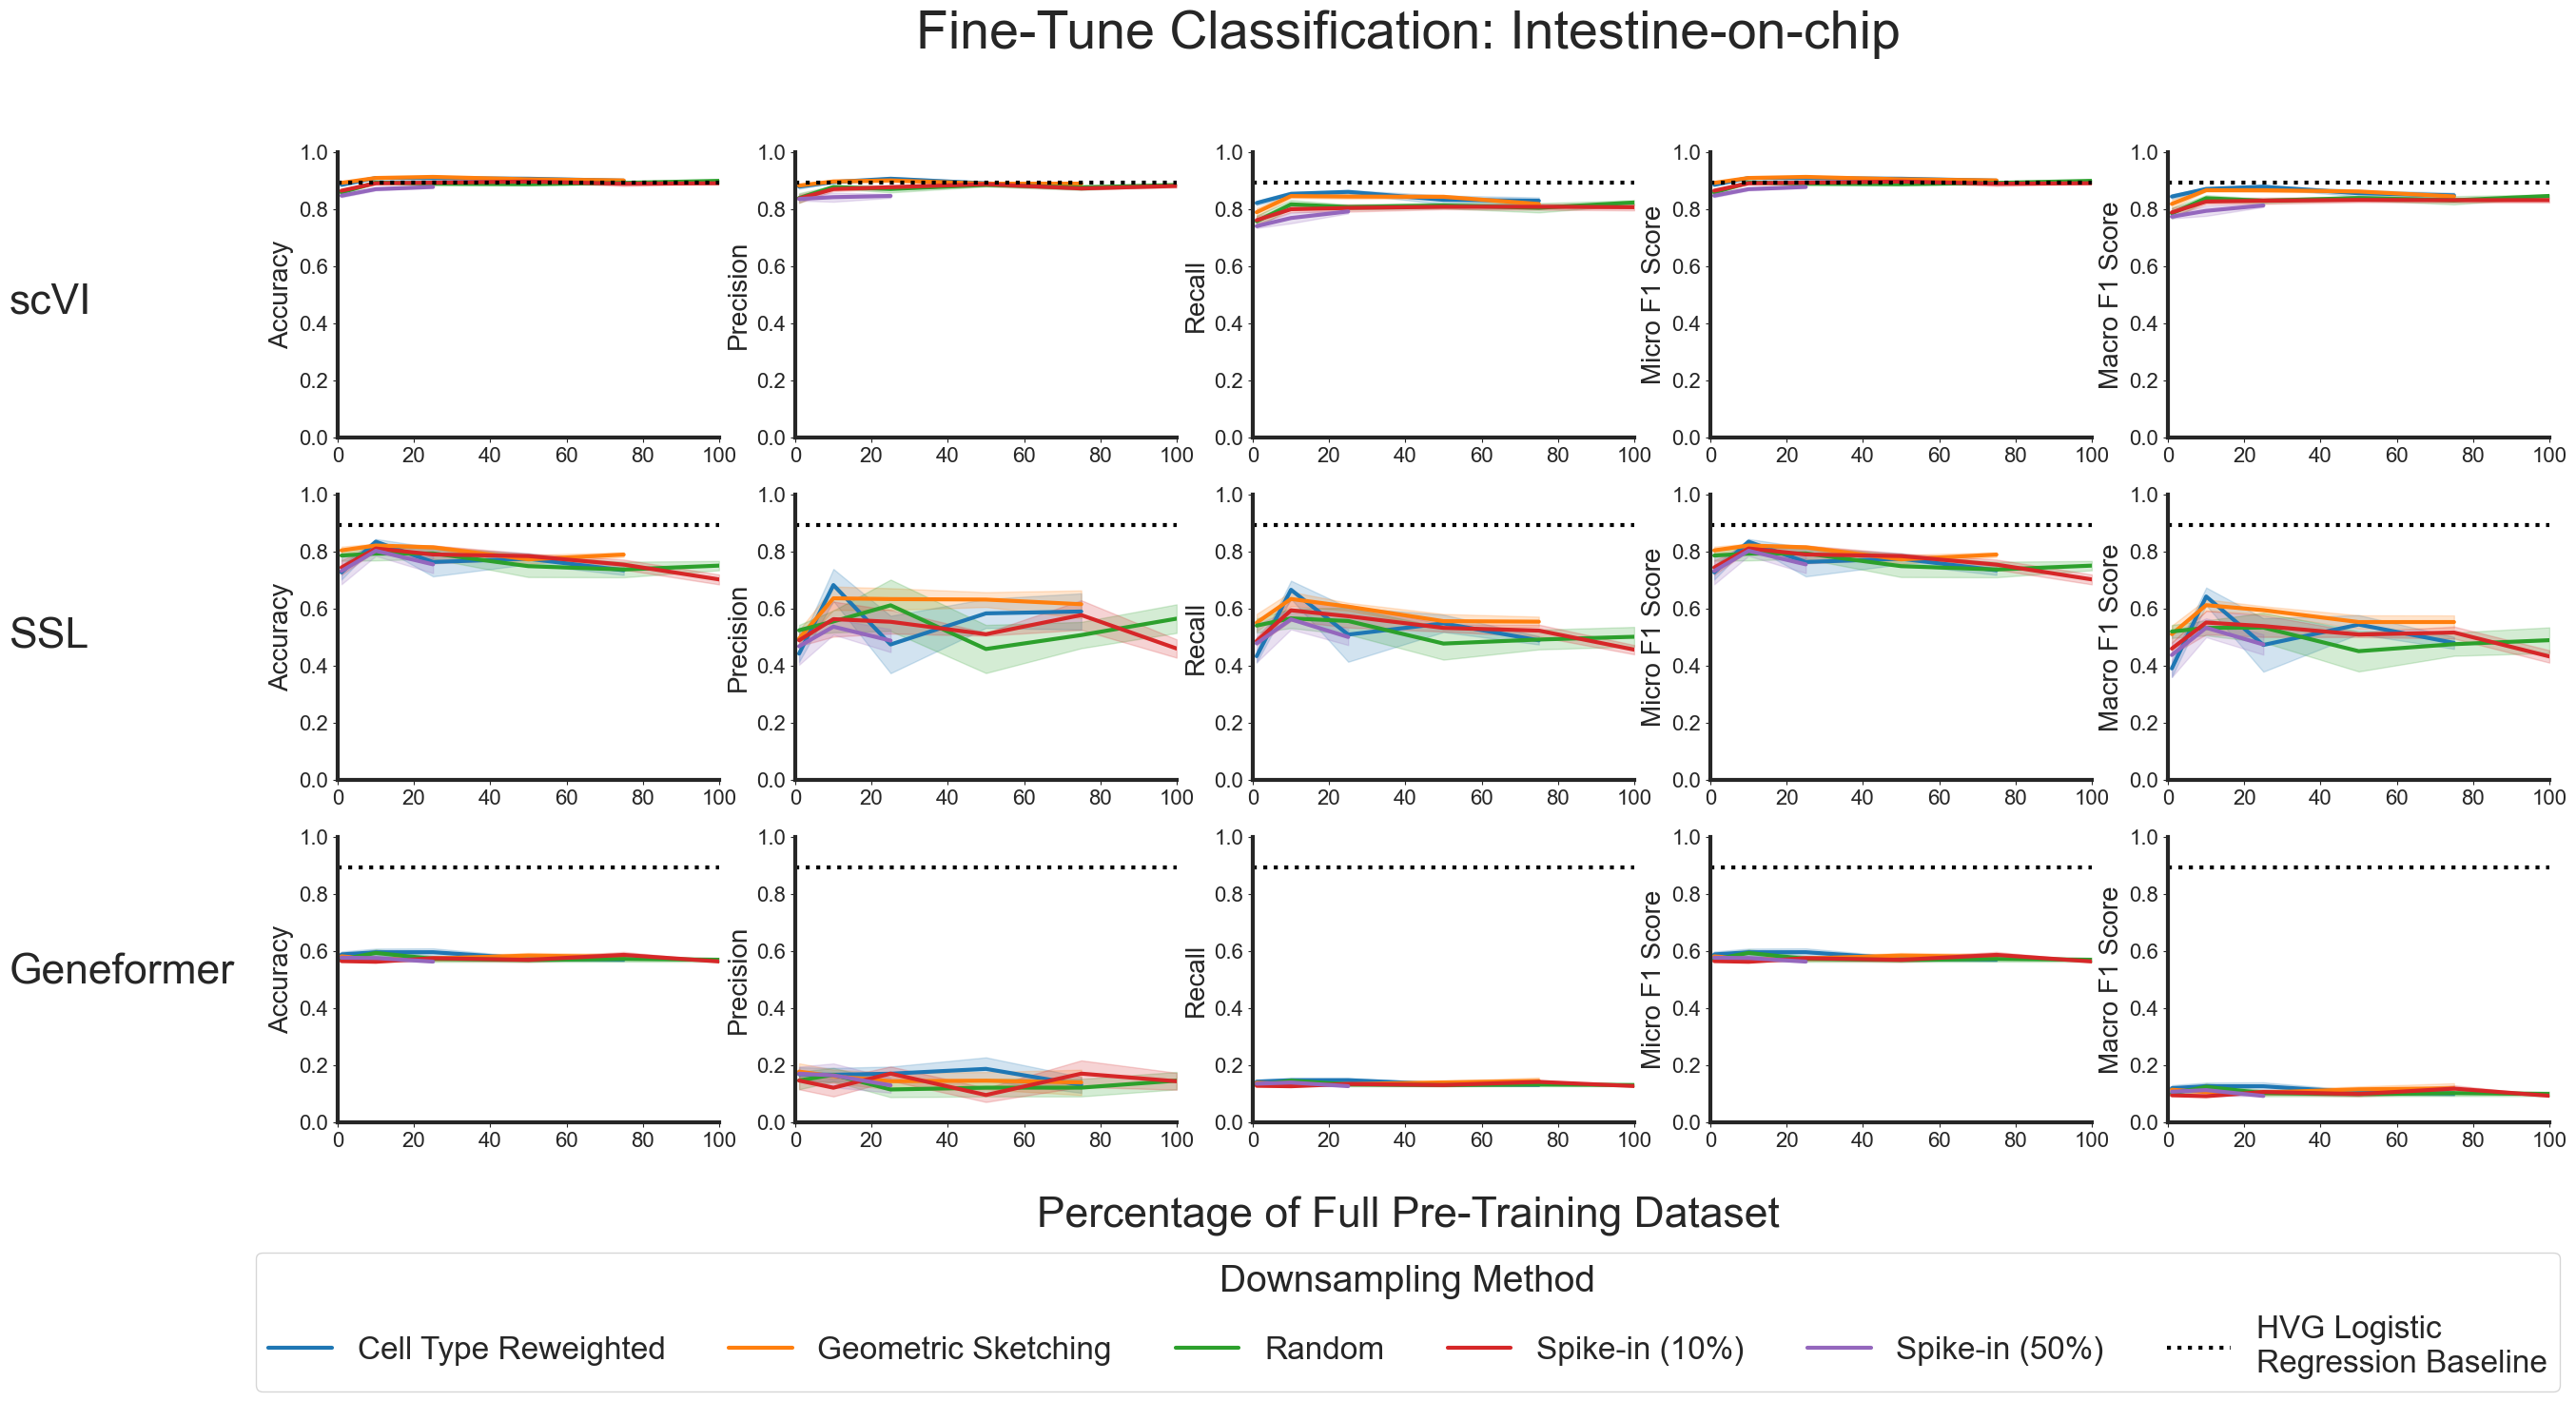

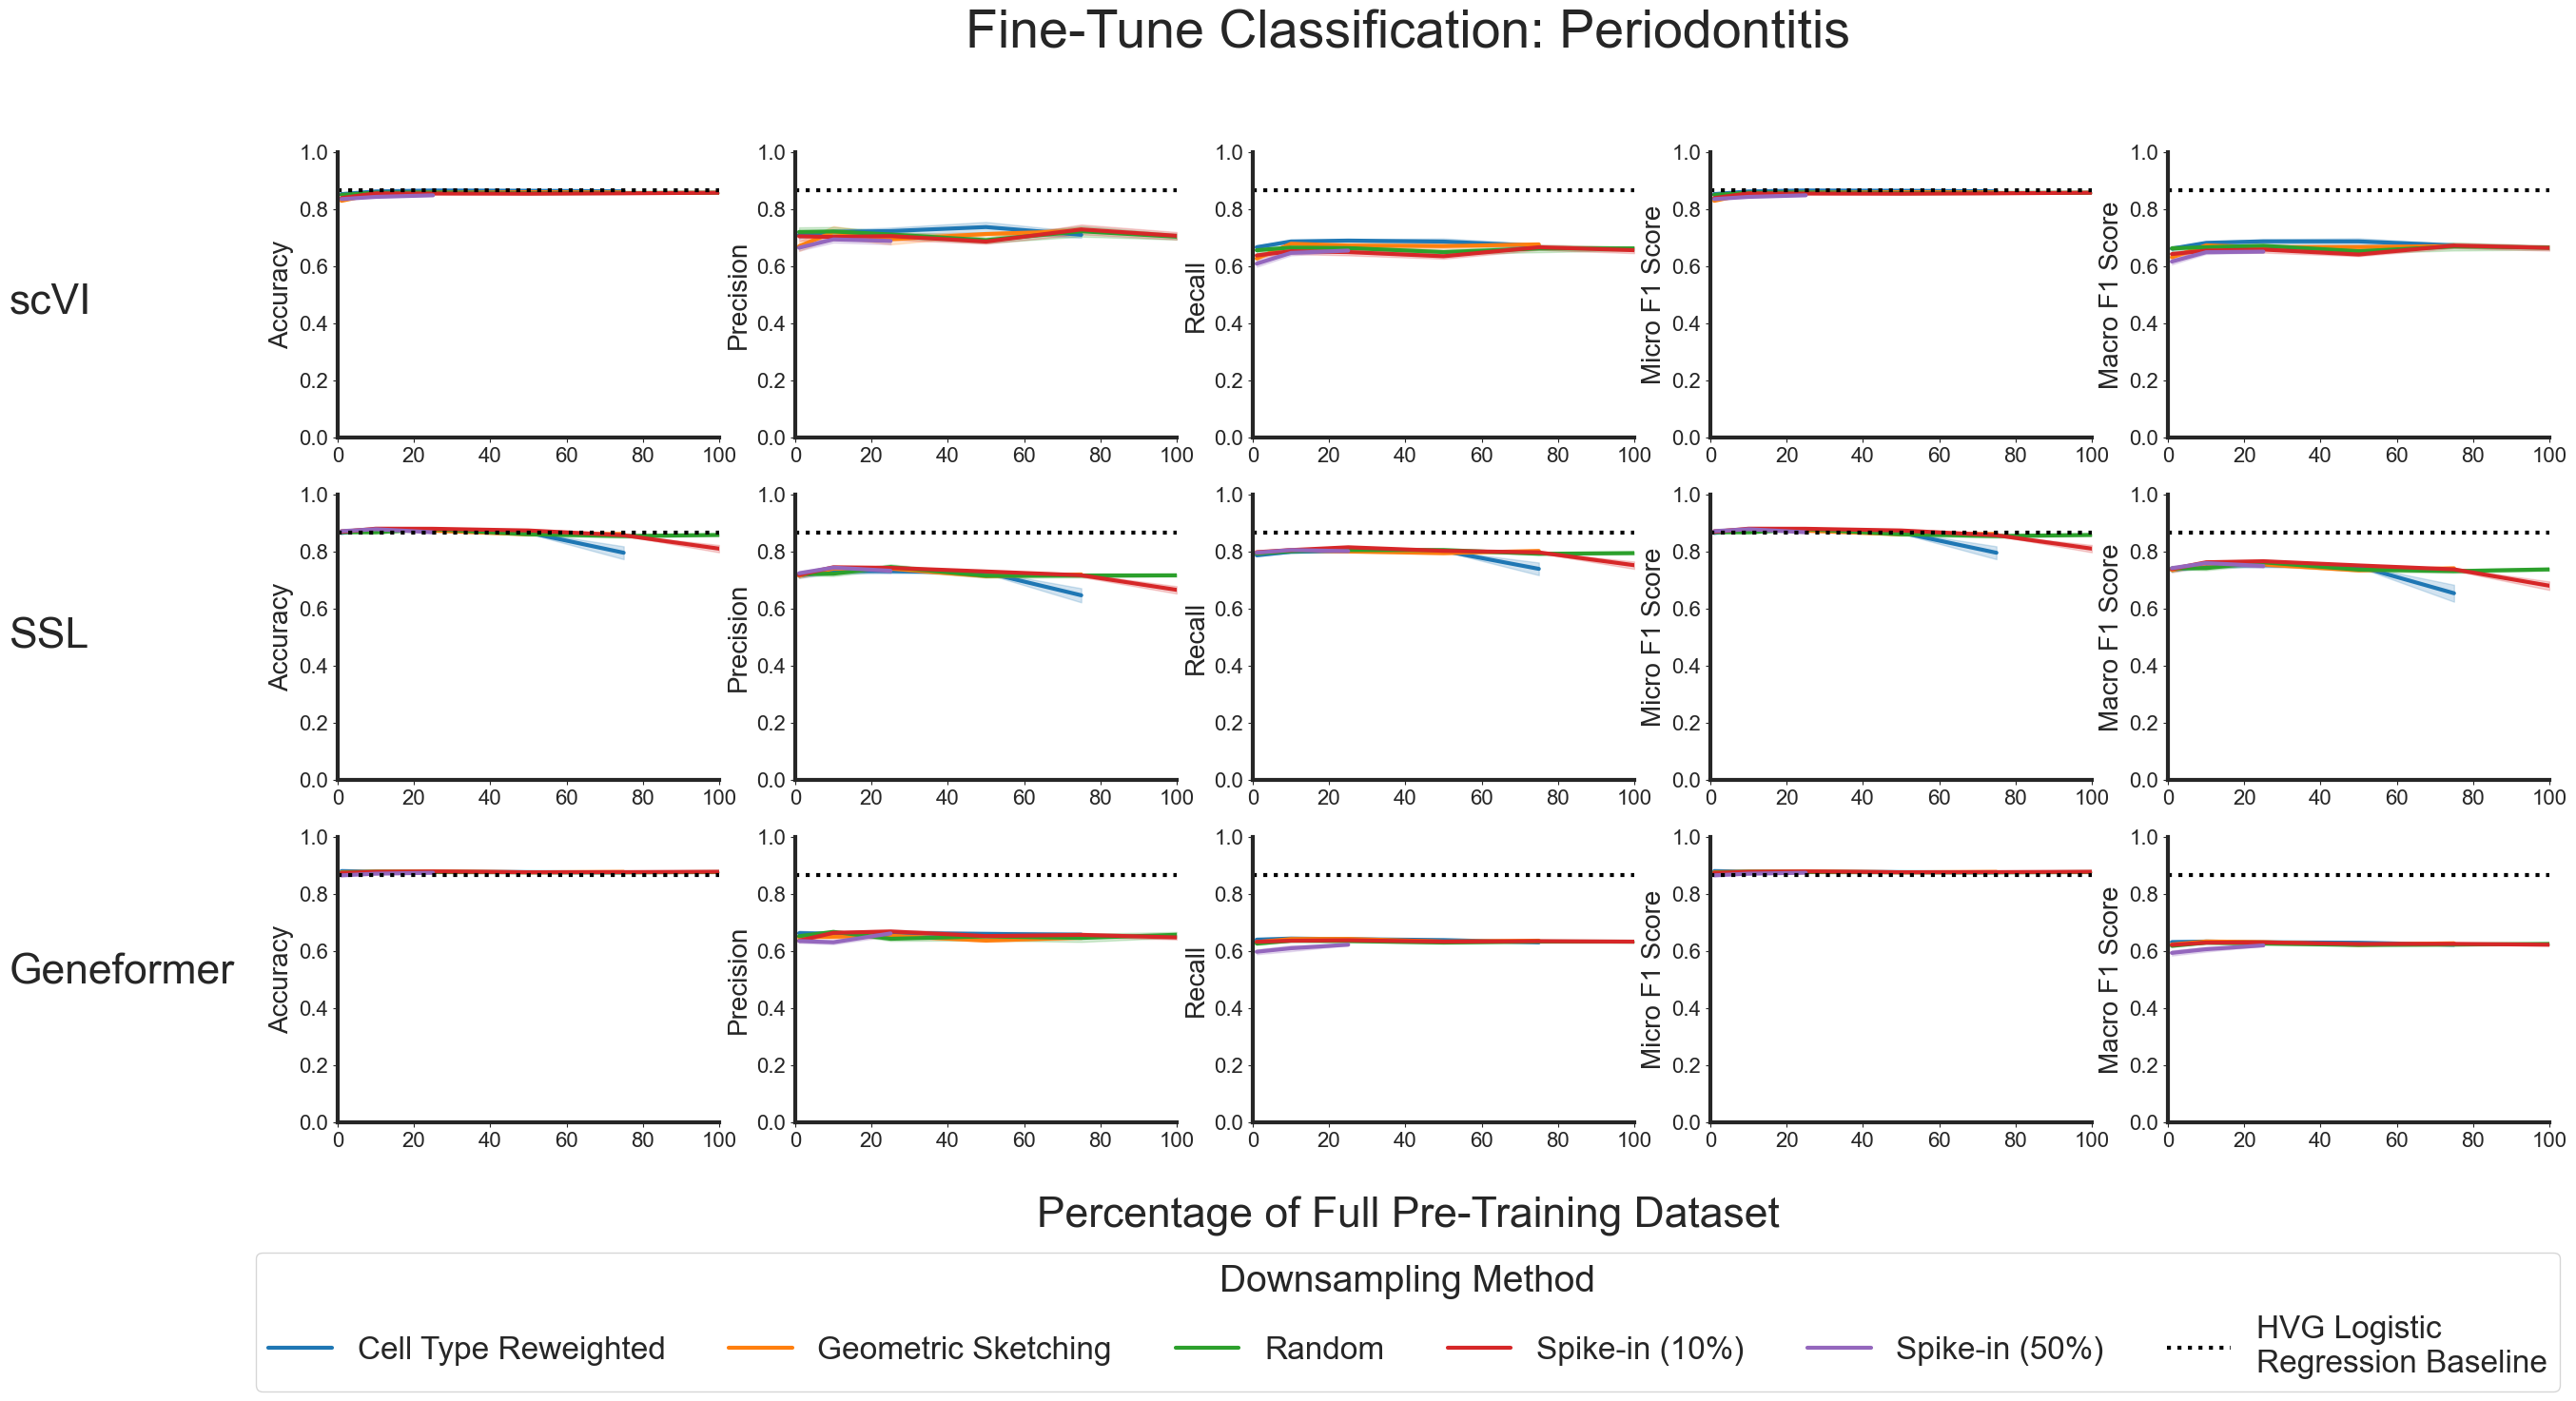

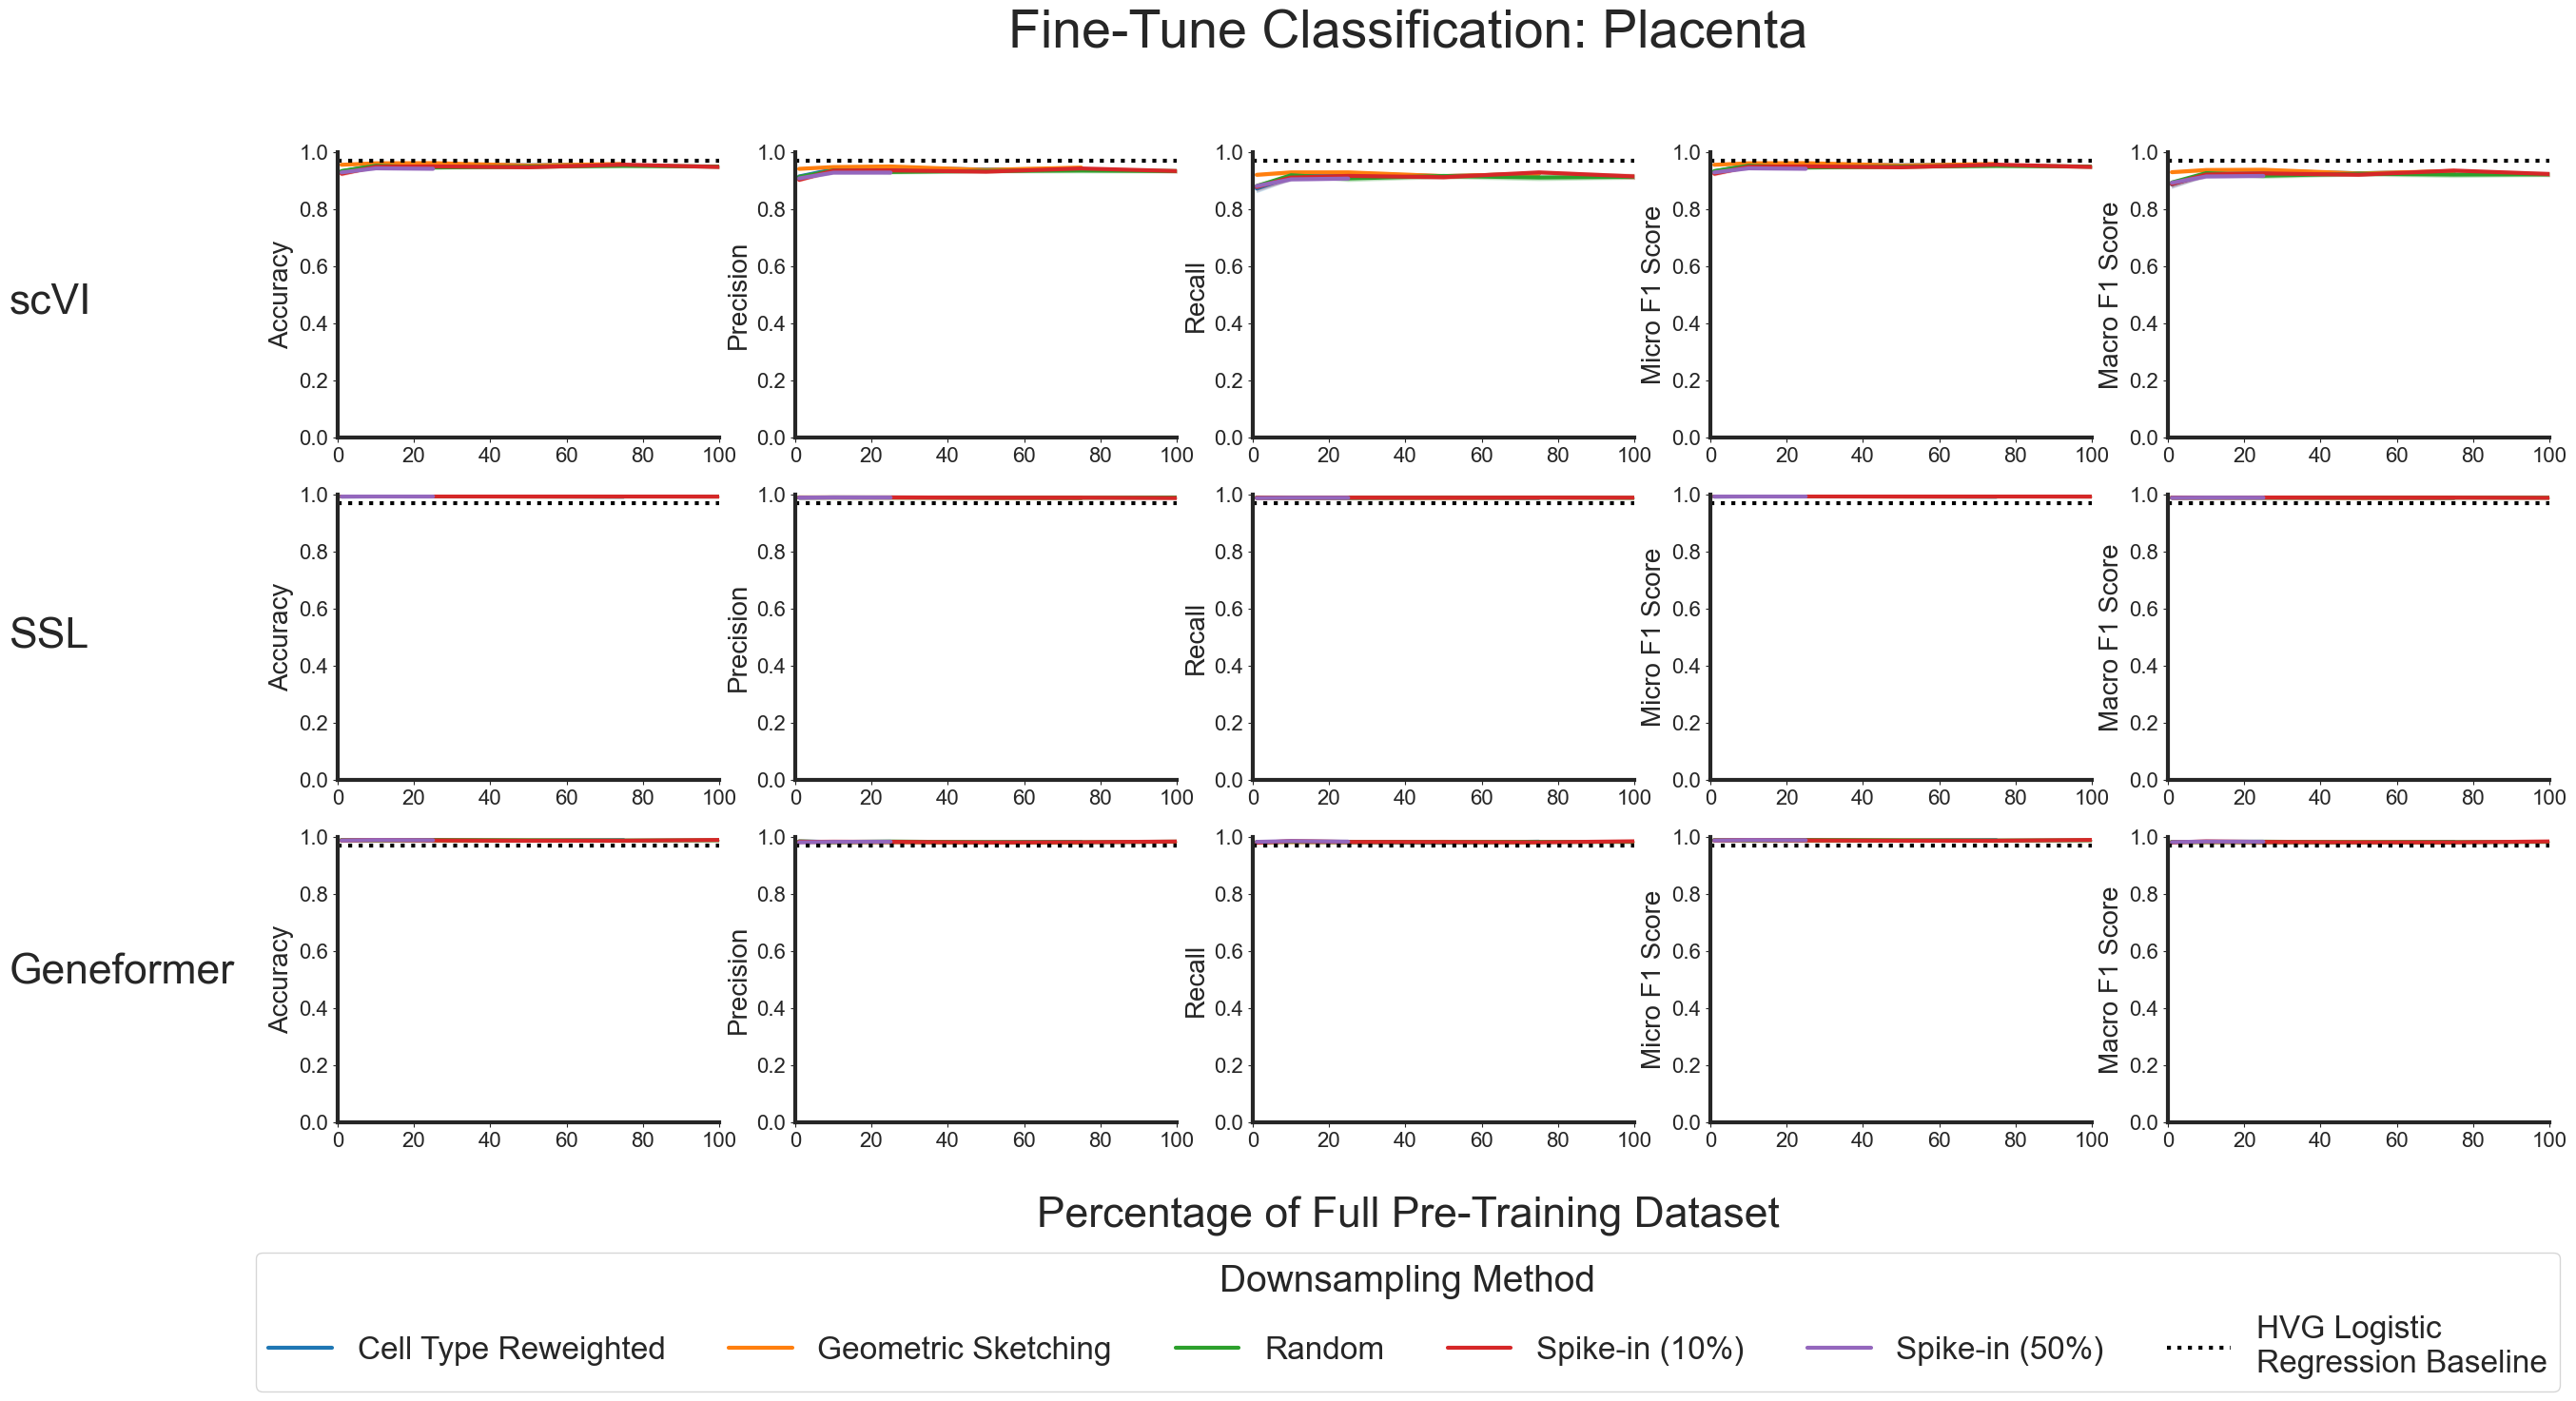

In [38]:
for dataset in ["hematopoiesis", "intestine", "periodontitis", "placenta"]:
    dataset_name = dataset.capitalize()
    
    if dataset == "intestine":
        dataset_name = "Intestine-on-Chip"
        
    finetuned_classification_plot(dataset, dataset_name)

# Supplemental Figures: Zero-Shot Integration (all metrics)

zeroshot integration kim_lung
Saving: figures/lineplots_metrics/kim_lung_zeroshot_integration.png
zeroshot integration periodontitis
Saving: figures/lineplots_metrics/periodontitis_zeroshot_integration.png


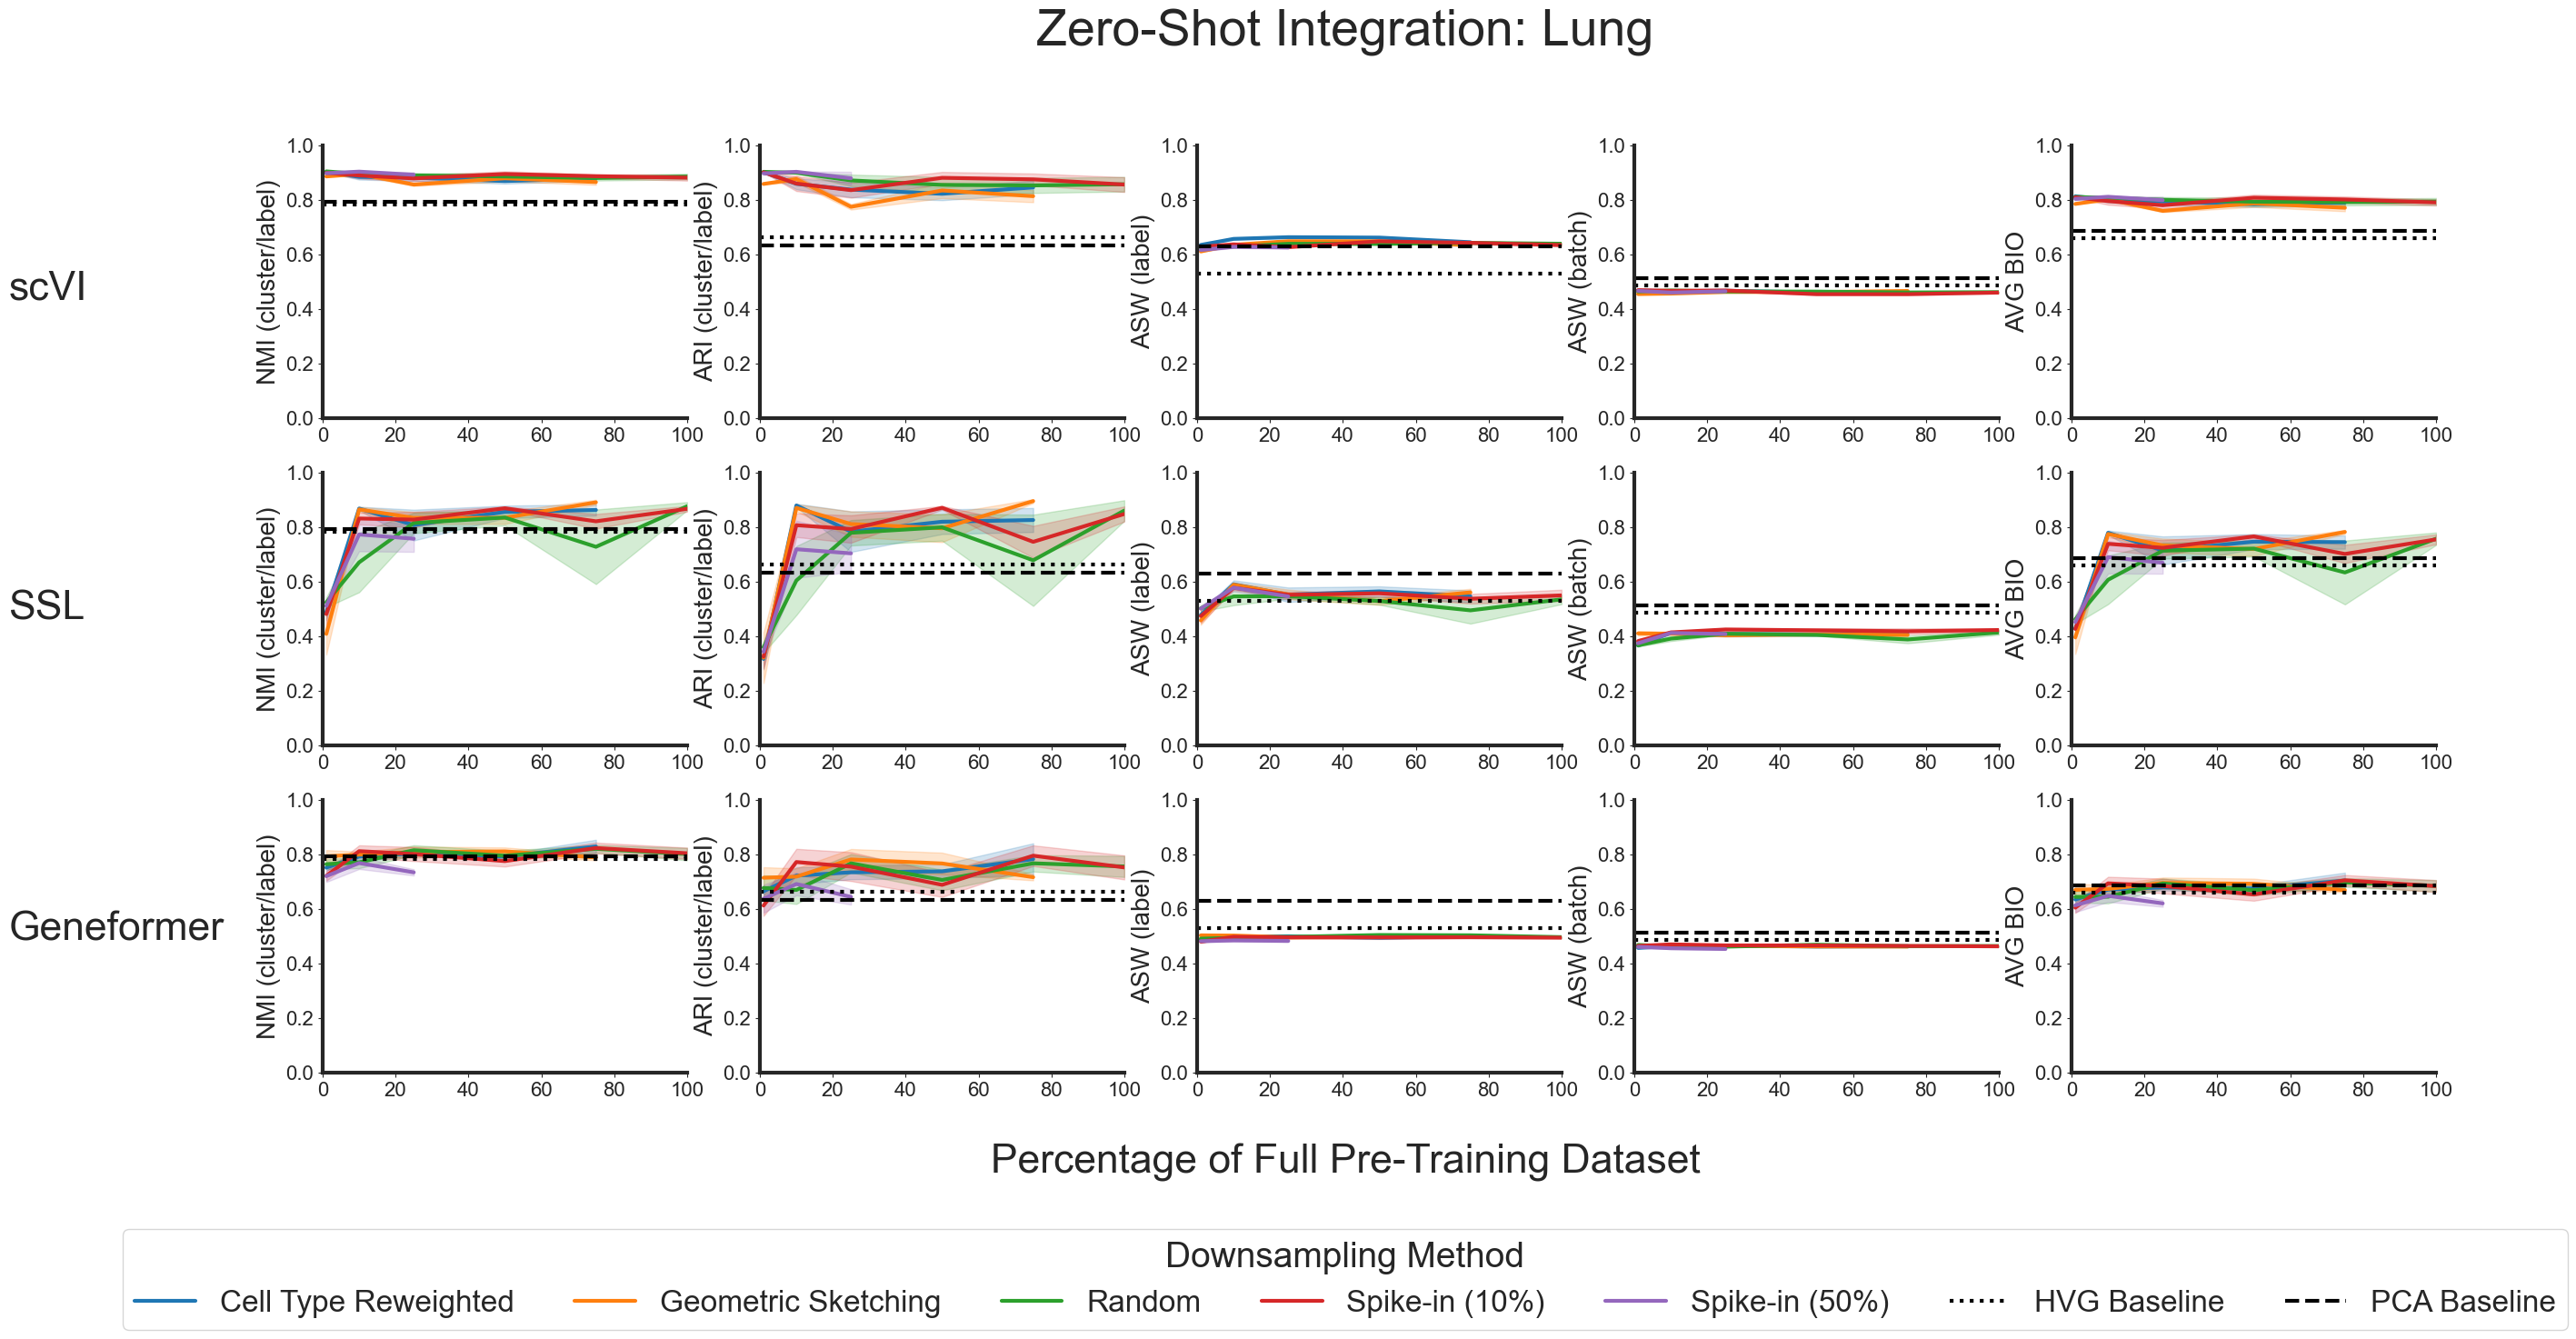

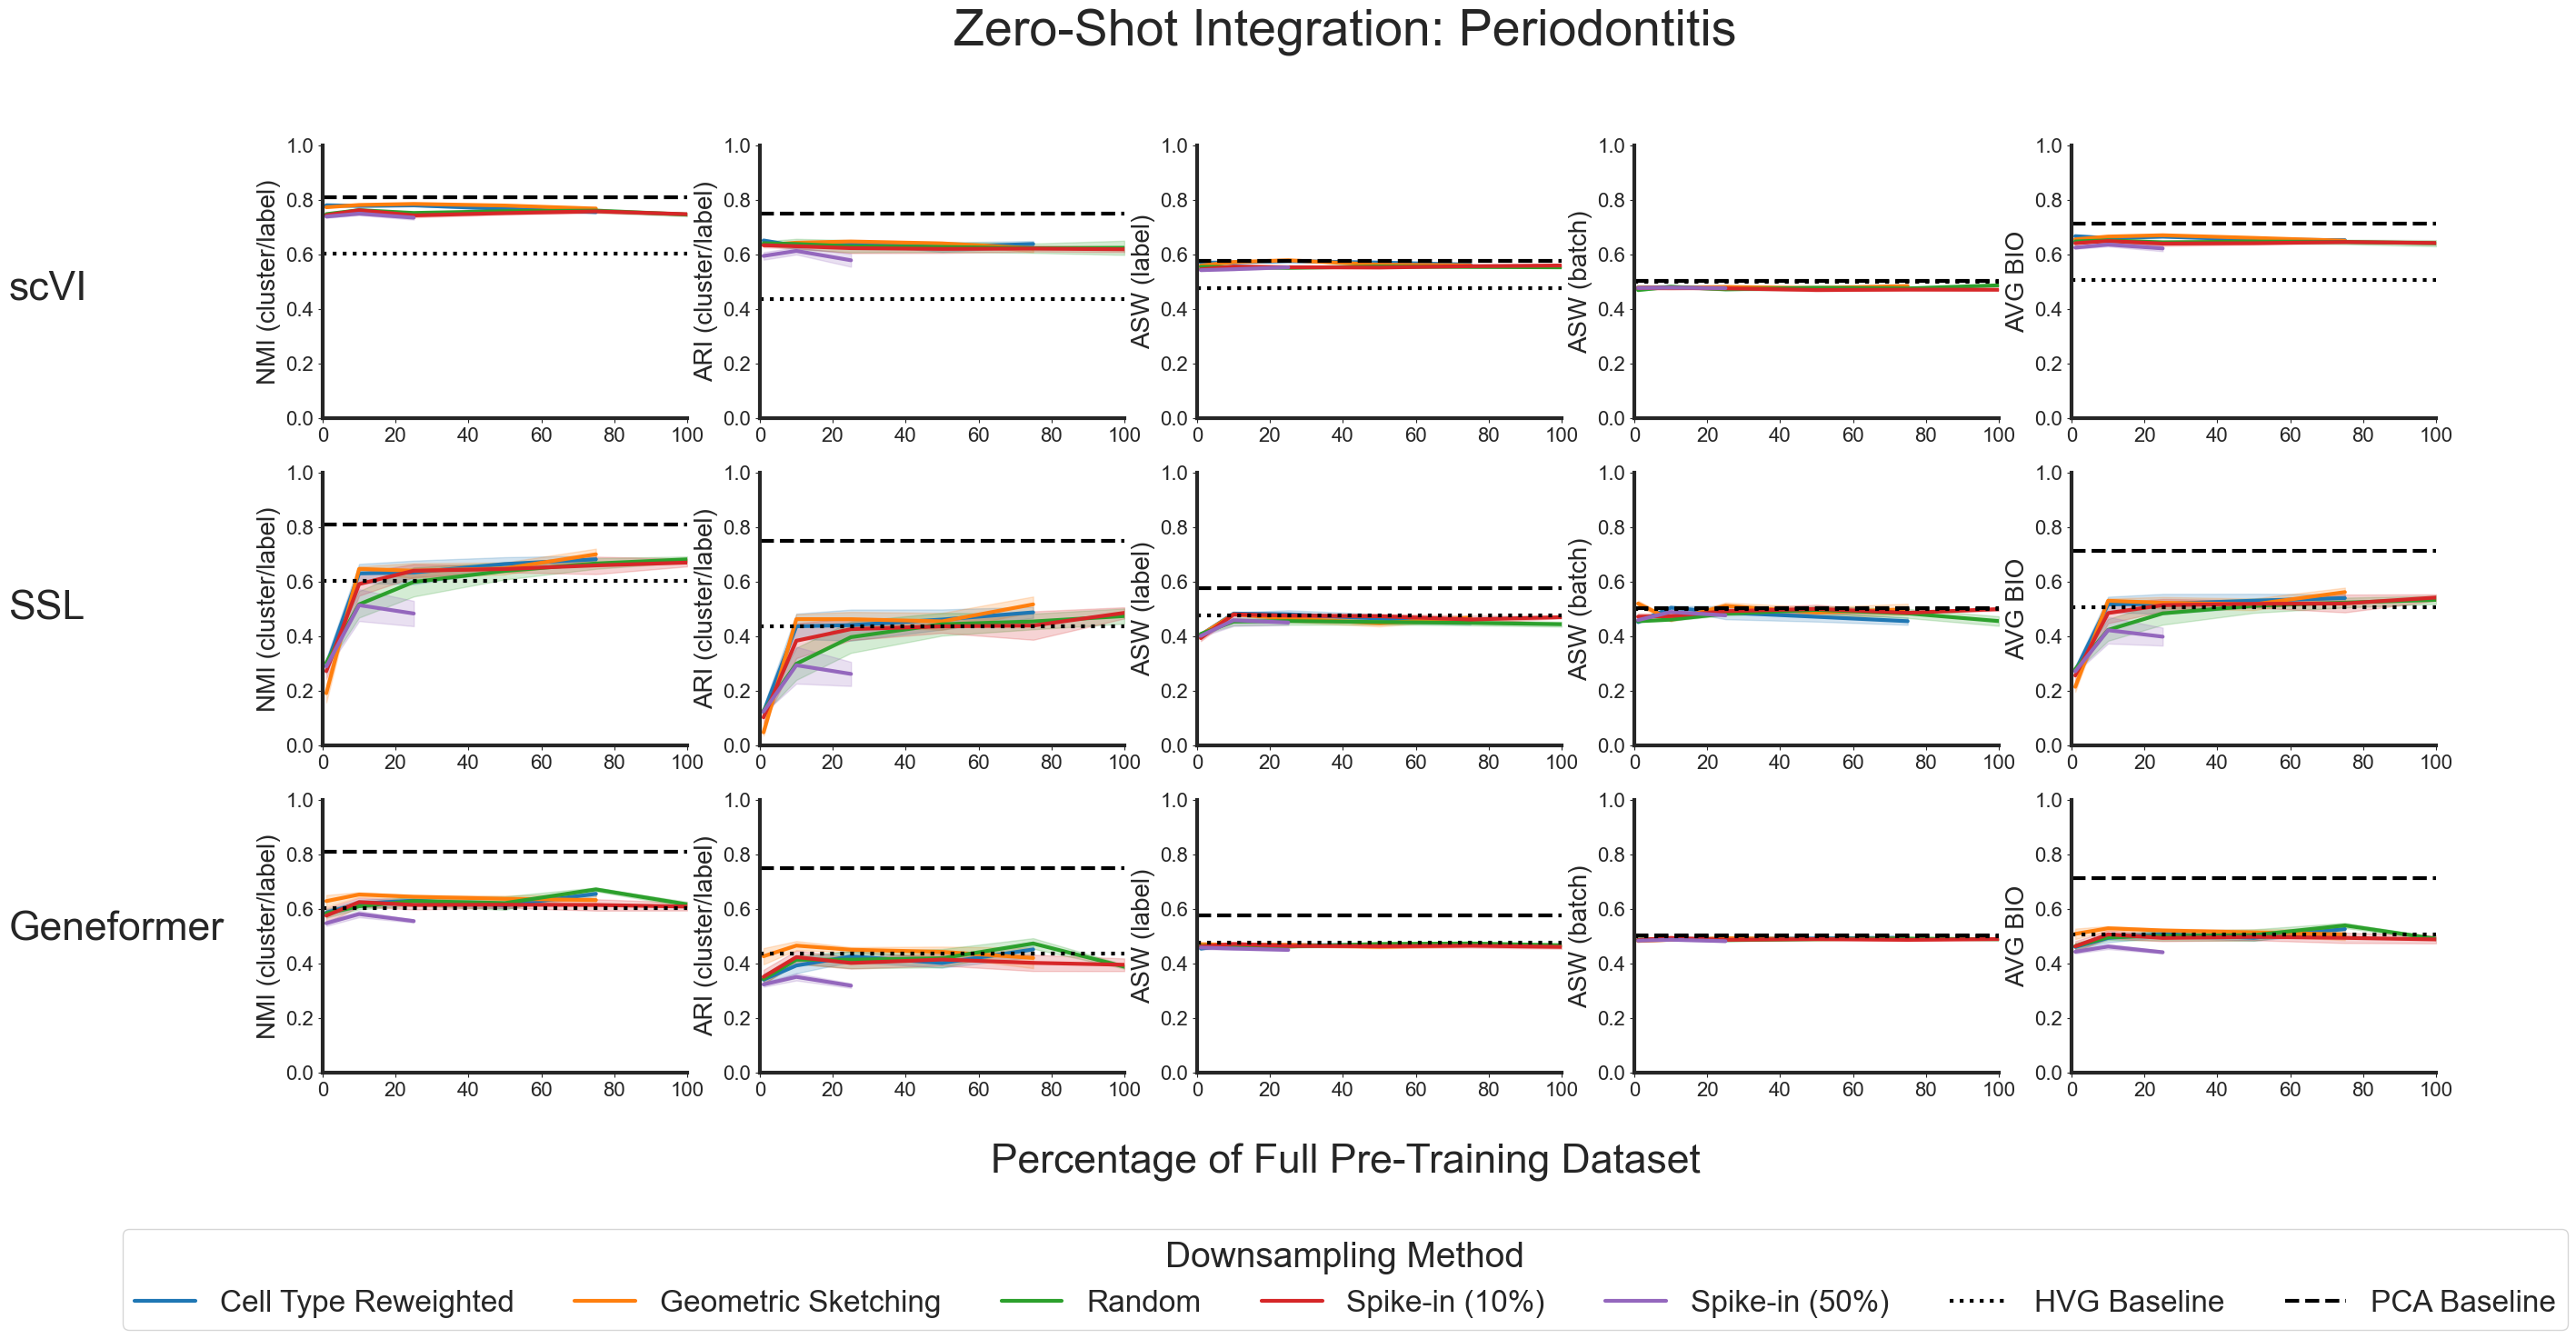

In [39]:
for dataset in ["kim_lung", "periodontitis"]:
    if dataset == "kim_lung":
        dataset_name = "Lung"
    else:
        dataset_name = dataset.capitalize()
    zero_shot_integration_plot(dataset, dataset_name)

plotting:
zeroshot scVI_0.5x hematopoiesis
plotting:
zeroshot scVI hematopoiesis
plotting:
zeroshot scVI_2x hematopoiesis
plotting:
zeroshot scVI_4x hematopoiesis
Saving: figures/lineplots/hematopoiesis_zeroshot_classification scVI Scaling.png


/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.lineplot(x='percentage',
/var/folders/pm/7b1k5l6x6xd1g2nqntx0rzj80000gn/T/ipykernel_37540/1616597515.py:80: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.lineplot(x='percentage',


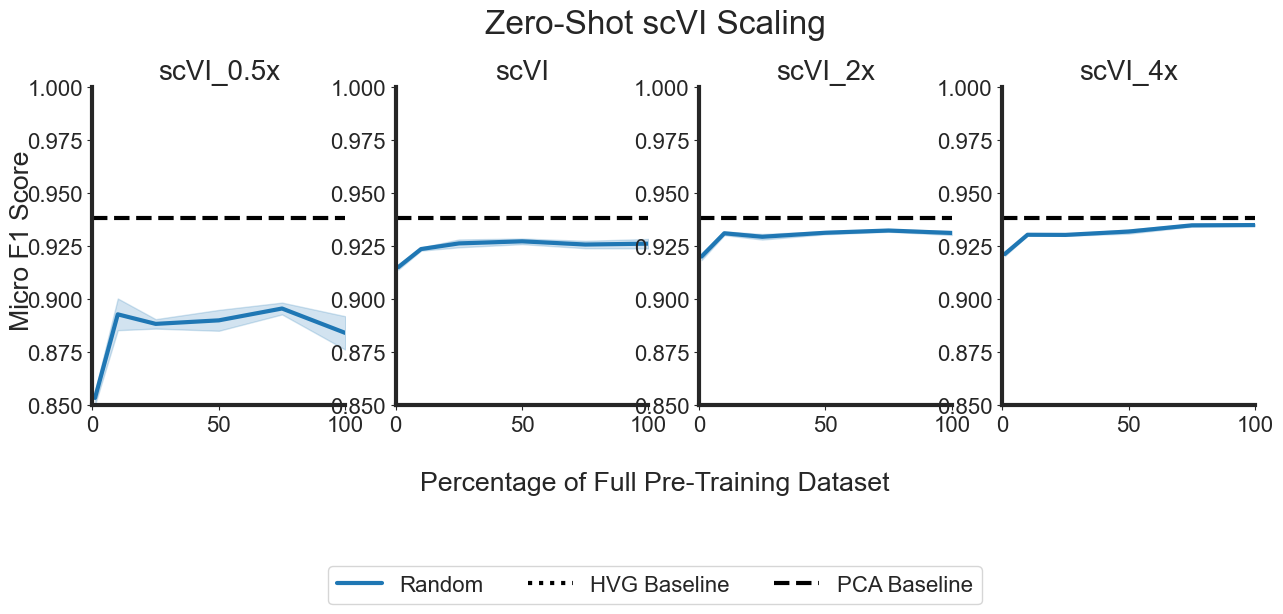

In [40]:
models = ["scVI_0.5x", "scVI", "scVI_2x", "scVI_4x"]
dataset = "hematopoiesis"
include_spikeins = False
include_downsampling_schemes = False

y_lim_low = 0.85

plot_main_metric(models, dataset, "zeroshot", "classification", include_spikeins, include_downsampling_schemes, y_lim_low, suffix = " scVI Scaling")
